In [34]:
from utils.BackTest import Engine, Strategy
import pandas as pd
import xgboost as xgb
import numpy as np
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import optuna
import optuna.visualization as vis
import os
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(r'../data/processed/merged_df_with_signals.csv')

In [4]:
df

,datetime,reddit_smoothed_sentiment_weibull_week,news_smoothed_sentiment_weibull_week,tele_smoothed_sentiment_weibull_week,Open,High,Low,Close,TOTAL_TRADES,TOTAL_TRADES_BUY,...,reddit_sentiment_log,news_sentiment_log,tele_sentiment_log,reddit_Signal,news_Signal,tele_Signal,typical_price,DATE,VWAP,VWAP_Signal
0,2024-01-27 13:00:00,0.000000,-857.923901,6.872941,41750.00,41806.55,41725.21,41742.44,35569,10171,...,0.000000,-6.755482,2.060767,0.0,-1.0,1.0,41758.066667,2024-01-27,41758.066667,-1
1,2024-01-27 14:00:00,0.027001,-867.694664,6.872941,41742.44,41818.39,41731.01,41766.00,27238,12281,...,0.026643,-6.766796,2.060767,1.0,-1.0,1.0,41771.800000,2024-01-27,41765.490372,1
2,2024-01-27 15:00:00,0.164191,-875.992357,6.872941,41766.00,41894.87,41733.60,41814.00,32410,14004,...,0.152026,-6.776304,2.060767,1.0,-1.0,1.0,41814.156667,2024-01-27,41784.423590,1
3,2024-01-27 16:00:00,0.300527,-882.407146,6.892280,41814.00,41895.74,41791.22,41810.18,30278,13664,...,0.262769,-6.783594,2.063227,1.0,-1.0,1.0,41832.380000,2024-01-27,41798.313570,1
4,2024-01-27 17:00:00,0.435303,-886.430380,6.892280,41810.18,41845.34,41774.07,41779.28,24681,9330,...,0.361376,-6.788139,2.063227,1.0,-1.0,1.0,41799.563333,2024-01-27,41798.533122,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10171,2025-03-26 08:00:00,-0.487101,-43.013907,12.500145,88140.45,88200.00,87886.10,87959.73,59816,30655,...,-0.396829,-3.780636,2.601147,-1.0,-1.0,1.0,88015.276667,2025-03-26,87642.510178,1
10172,2025-03-26 09:00:00,-0.456887,-39.331997,12.500145,87959.73,88056.61,87837.49,87939.99,43067,23857,...,-0.376302,-3.692921,2.601147,-1.0,-1.0,1.0,87944.696667,2025-03-26,87661.828105,1
10173,2025-03-26 10:00:00,-0.427685,-37.038648,12.500145,87939.99,88259.81,87939.99,88208.47,55584,29793,...,-0.356054,-3.634124,2.601147,-1.0,-1.0,1.0,88136.090000,2025-03-26,87701.167882,1
10174,2025-03-26 11:00:00,-0.399548,-37.530942,12.500145,88208.47,88242.00,87923.91,87954.96,67105,30529,...,-0.336149,-3.647040,2.601147,-1.0,-1.0,1.0,88040.290000,2025-03-26,87742.875495,1


In [5]:
base_price_data = ['datetime','Close','Open','High','Low','VOLUME']

technical_indicators = [
    # Trend Indicators
    'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
    'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',

    # Momentum Indicators
    'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
    'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
    '%K', '%D', 'Stochastic_Signal',

    # Volatility Indicators
    'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',

    # Volume-Based Indicators
    'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
]

sentiment_indicators = [
    'reddit_sentiment_log',
    'tele_sentiment_log',
    'news_sentiment_log',
]

# Create a new DataFrame with the selected columns
selected_columns = base_price_data + technical_indicators + sentiment_indicators
df_selected = df[selected_columns]

In [6]:
working_frame = df_selected.copy().set_index(pd.to_datetime(df_selected['datetime'])).drop(columns=['datetime'])
working_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-27 13:00:00,41742.44,41750.00,41806.55,41725.21,419.38468,41729.550796,41714.525206,41617.761701,1,41720.541302,...,41524.488454,175.710000,81.34,-419.38468,-65.712408,0,-1,0.000000,2.060767,-6.755482
2024-01-27 14:00:00,41766.00,41742.44,41818.39,41731.01,493.43458,41737.650619,41721.878748,41631.237910,1,41727.534948,...,41541.267296,140.500000,87.38,493.43458,-12.460314,1,1,0.026643,2.060767,-6.766796
2024-01-27 15:00:00,41814.00,41766.00,41894.87,41733.60,581.25856,41754.617148,41735.038927,41647.852645,1,41740.837263,...,41561.147977,109.318333,161.27,581.25856,44.084341,0,1,0.152026,2.060767,-6.776304
2024-01-27 16:00:00,41810.18,41814.00,41895.74,41791.22,609.18361,41766.964449,41745.773366,41662.609678,1,41751.505377,...,41571.210298,101.921667,104.52,-609.18361,-18.131655,-1,1,0.262769,2.063227,-6.783594
2024-01-27 17:00:00,41779.28,41810.18,41845.34,41774.07,448.23397,41769.701238,41750.560028,41673.216071,1,41755.778396,...,41588.600128,99.801667,71.27,-448.23397,-59.093780,0,-1,0.361376,2.063227,-6.788139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26 08:00:00,87959.73,88140.45,88200.00,87886.10,525.11331,87756.884904,87689.841782,87613.211597,1,87700.669674,...,87158.682498,418.066667,313.90,-525.11331,59.670458,-1,1,-0.396829,2.601147,-3.780636
2025-03-26 09:00:00,87939.99,87959.73,88056.61,87837.49,393.09750,87797.574925,87725.577241,87642.918724,1,87737.488186,...,87170.539414,392.118333,219.12,-393.09750,16.549700,0,1,-0.376302,2.601147,-3.692921
2025-03-26 10:00:00,88208.47,87939.99,88259.81,87939.99,556.20541,87888.884942,87794.561921,87694.332477,1,87809.946926,...,87154.234720,378.148333,319.82,556.20541,67.945482,1,1,-0.356054,2.601147,-3.634124


In [7]:
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('xgboost_model.json')

In [8]:
loaded_final_model = xgb.XGBRegressor()
loaded_final_model.load_model('xgboost_model_final.json')

In [9]:
labels = pd.read_parquet(f'../data/processed/labels_btc.parquet')
inputs = np.load(f'../data/processed/inputs_btc.npy')

In [ ]:
class XGBoostStrategy(Strategy):
    def __init__(self,model,bet_size = 0.1,initial_data=None):
        super().__init__()
        self.model = model 
        self.initial_data = initial_data
        self.bet_size = bet_size  # 10% of cash

    def on_bar(self):

        temp_df = pd.concat([self.initial_data, self.data])

        features = self.sequencing_data(temp_df, window_size=6)

        # ###TESTING INPUTS###
        # print("Current index:", self.current_idx)

        # idx = labels[labels['inference_date'] == self.current_idx].index
        # arr = inputs[idx]
        # are_close = np.allclose(arr, features, atol=1e-5)

        # print("Arrays are close:", are_close)

        # if self.current_idx == pd.to_datetime('2025-02-28 00:00:00'):
        #     print(features)

        predictions = self.model.predict(features)
        signal = self.determine_signal(predictions)
        if signal == 1:
            self.buy(
                "btc",
               size = round(self.bet_size * (self.cash) / self.close(), 8)
            )
        elif signal == -1:
            self.sell(
                "btc",
                size = round( self.bet_size * (self.cash) / self.close(), 8)
            )
        else:
            pass

    def determine_signal(self, predictions):
        """Determine buy/sell/hold signal based on predictions."""
        future_forecasts = predictions.flatten().tolist()  # Convert to list if needed
        close = self.close()

        above_close = sum(forecast > close for forecast in future_forecasts)
        below_close = sum(forecast < close for forecast in future_forecasts)

        if above_close >= 3:
            return 1  # Buy
        elif below_close >= 3:
            return -1  # Sell
        else:
           return 0  # Hold
        
    def sequencing_data(self, df, window_size=6):
        start_time = self.current_idx - pd.Timedelta(hours=window_size)
        past_data = df.loc[start_time:self.current_idx]

        # Collect past feature lists
        past_features = [
            past_data['Close'].tolist(),
            past_data['High'].tolist(),
            past_data['Low'].tolist(),
            past_data['VOLUME'].tolist()
        ]

        # Technical Indicators
        indicators = [
            'EMA_8', 'EMA_13', 'EMA_21', 'EMA_Signal', 'EMA_short', 'EMA_long',
            'SMA20', 'SMA_50', 'SMA_200', 'GoldenCross_Signal',
            'MACD', 'Signal_Line', 'MACD_Signal', 'MACD_Hist',
            'RSI_14', 'BB_RSI_Signal', 'RSI_Signal',
            '%K', '%D', 'Stochastic_Signal',
            'STD20', 'Upper_BB', 'Lower_BB', 'ATR', 'TR',
            'OBV', 'OBV_EMA20', 'OBV_Signal', 'VWAP_Signal'
        ]
        
        for indicator in indicators:
            past_features.append(past_data[indicator].tolist())

        # Sentiment indicators
        sentiments = ['reddit_sentiment_log', 'tele_sentiment_log', 'news_sentiment_log']
        
        for sentiment in sentiments:
            past_features.append(past_data[sentiment].tolist())

        # Convert to 1D NumPy array and reshape to (1, 252)
        past_features_array = np.concatenate(past_features).reshape(1, -1)
        
        return past_features_array  # Shape: (1, 252)

In [11]:
initial_val_frame = working_frame[(working_frame.index >= pd.to_datetime('2025-01-01') - pd.Timedelta(hours=6)) & (working_frame.index < '2025-01-01')]
validate_frame = working_frame[(working_frame.index >= '2025-01-01') & (working_frame.index < '2025-03-01')]

initial_test_frame = working_frame[(working_frame.index >= pd.to_datetime('2025-03-01') - pd.Timedelta(hours=6)) & (working_frame.index < '2025-03-01')]
test_frame = working_frame[working_frame.index >= '2025-03-01']

In [12]:
validate_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,94401.14,93576.00,94509.42,93489.03,755.99010,94011.893818,94029.638251,93958.906655,0,94032.973503,...,92381.690536,622.563333,1020.39,755.99010,103.811170,0,1,0.450214,2.029984,-6.587146
2025-01-01 01:00:00,93607.74,94401.14,94408.72,93578.77,586.53456,93922.081858,93969.367072,93926.982413,-1,93967.552964,...,92563.555167,664.478333,829.95,-586.53456,38.063957,-1,-1,0.375333,2.029984,-6.607708
2025-01-01 02:00:00,94098.91,93607.74,94105.12,93594.56,276.78045,93961.377001,93987.873205,93942.612194,0,93987.761739,...,92755.139100,620.850000,510.56,276.78045,60.798861,1,1,0.295866,2.029984,-6.627062
2025-01-01 03:00:00,93838.04,94098.91,94098.91,93728.22,220.99302,93933.968779,93966.468461,93933.105631,0,93964.727625,...,92934.645329,606.051667,370.69,-220.99302,33.961539,-1,-1,0.211558,2.029984,-6.644706
2025-01-01 04:00:00,93553.91,93838.04,93838.04,93500.00,279.46909,93849.511272,93907.531538,93898.633301,-1,93901.524914,...,92885.780670,575.041667,338.04,-279.46909,4.111003,0,-1,0.122122,2.029984,-6.659001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 19:00:00,84449.99,84440.97,84810.35,84209.84,1656.89446,83302.202137,82785.136766,82669.910295,1,82850.241395,...,77705.107174,1456.295000,600.51,1656.89446,484.835909,0,1,-1.221349,0.913890,-8.396762
2025-02-28 20:00:00,84191.27,84449.99,84795.03,83600.00,2215.50549,83499.772773,82986.012942,82808.215723,1,83056.553488,...,77711.558133,1409.260000,1195.03,-2215.50549,227.660538,-1,1,-1.246760,0.913890,-8.393514
2025-02-28 21:00:00,84258.37,84191.27,84596.00,84000.17,862.30163,83668.349935,83167.778236,82940.047930,1,83241.448336,...,77655.745657,1103.960000,595.83,862.30163,288.102547,1,1,-1.269582,0.919505,-8.389415


In [13]:
initial_val_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2024-12-31 18:00:00,93875.68,94120.94,94416.72,93779.80,816.81017,94452.342269,94276.150021,94036.116190,1,94314.297882,...,91418.780827,1160.111667,636.92,-816.81017,43.134507,0,-1,0.644116,1.968432,-6.413587
2024-12-31 19:00:00,94166.88,93875.68,94290.91,93712.45,462.79342,94388.906209,94260.540018,94048.003809,1,94291.618208,...,91518.783895,1001.461667,578.46,462.79342,83.102023,1,1,0.618698,2.029984,-6.449630
2024-12-31 20:00:00,93564.04,94166.88,94222.50,93450.17,733.04147,94205.602607,94161.040016,94004.007099,1,94179.683099,...,91657.553926,983.908333,772.33,-733.04147,5.374071,-1,-1,0.592473,2.029984,-6.482636
2024-12-31 21:00:00,93899.68,93564.04,93964.15,93504.67,337.52715,94137.619805,94123.702871,93994.522817,1,94136.605699,...,91830.596274,881.571667,459.48,337.52715,37.007698,1,-1,0.565590,2.029984,-6.514657
2024-12-31 22:00:00,93488.84,93899.68,93899.68,93375.58,315.53272,93993.446515,94033.008175,93948.551652,0,94036.949438,...,91979.914579,804.901667,524.10,-315.53272,3.432420,-1,-1,0.538200,2.029984,-6.543260
2024-12-31 23:00:00,93576.00,93488.84,93756.00,93375.38,336.57995,93900.680623,93967.721293,93914.683320,-1,93966.034140,...,92141.877951,558.651667,380.62,336.57995,35.160756,1,-1,0.510451,2.029984,-6.566459


In [14]:
# Store all trials' results
all_trials = []

def objective(trial):
    # Optimize bet size between 1% and 50% of capital
    bet_size = trial.suggest_float("bet_size", 0.01, 0.5)  

    # Run backtest with the given bet size
    e = Engine()
    e.add_data(validate_frame)
    e.add_strategy(XGBoostStrategy(model=loaded_model, bet_size=bet_size,initial_data= initial_val_frame))  # Pass optimized bet size

    stats = e.run()

    # Save trial results
    trial_result = {
        "trial": trial.number,
        "sharpe": stats.get("Strategy Sharpe Ratio", np.nan),
        "return": stats.get("Total Return (%)", np.nan),
        "drawdown": stats.get("Strategy Max Drawdown (%)", np.nan),
        "bet_size": bet_size,
    }
    all_trials.append(trial_result)

    return trial_result["sharpe"]  # Optimize for Sharpe Ratio

# Run optimization
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

# Save results
results_df = pd.DataFrame(all_trials)

print("Best Sharpe:", study.best_value)
print("Best Bet Size:", study.best_params["bet_size"])


[I 2025-04-04 09:22:25,614] A new study created in memory with name: no-name-4b6e6ed5-1839-47e5-b742-7a1b8643fb9e
100%|██████████| 1416/1416 [00:03<00:00, 458.23it/s]
[I 2025-04-04 09:22:28,734] Trial 0 finished with value: -1.576224126342443 and parameters: {'bet_size': 0.19352465823520762}. Best is trial 0 with value: -1.576224126342443.


Initial Portfolio Value: 100000
Holding Cash Value: 11083.712554471982
Final Positions Value: 84327.78548825902 , Final Size: 0.9997373500000002
Final Portfolio Value: 95411.498042731
Final Portfolio Value: 95411.498042731
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -4.59
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -87.33
Strategy CAGR (%)                        |     -18.46
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.71
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.58
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.70
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 456.99it/s]
[I 2025-04-04 09:22:31,851] Trial 1 finished with value: -0.3892266970895697 and parameters: {'bet_size': 0.4758500101408589}. Best is trial 1 with value: -0.3892266970895697.


Initial Portfolio Value: 100000
Holding Cash Value: 31667.697405713785
Final Positions Value: 67284.85480627703 , Final Size: 0.7976870500000003
Final Portfolio Value: 98952.55221199081
Final Portfolio Value: 98952.55221199081
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.05
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -87.64
Strategy CAGR (%)                        |      -4.47
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.49
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.39
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.77
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 458.52it/s]
[I 2025-04-04 09:22:34,955] Trial 2 finished with value: -0.5758250021910675 and parameters: {'bet_size': 0.3686770314875885}. Best is trial 1 with value: -0.3892266970895697.


Initial Portfolio Value: 100000
Holding Cash Value: 8385.909697030918
Final Positions Value: 90060.26561211779 , Final Size: 1.0676980400000022
Final Portfolio Value: 98446.1753091487
Final Portfolio Value: 98446.1753091487
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.55
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -83.45
Strategy CAGR (%)                        |      -6.58
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.42
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.58
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.40
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 382.62it/s]
[I 2025-04-04 09:22:38,668] Trial 3 finished with value: 1.6307280631109107 and parameters: {'bet_size': 0.30334265725654797}. Best is trial 3 with value: 1.6307280631109107.


Initial Portfolio Value: 100000
Holding Cash Value: 23282.079517163933
Final Positions Value: 80542.71773416255 , Final Size: 0.9548639600000017
Final Portfolio Value: 103824.79725132648
Final Portfolio Value: 103824.79725132648
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.82
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -80.05
Strategy CAGR (%)                        |      17.71
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.86
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.63
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.73
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:02<00:00, 504.77it/s]
[I 2025-04-04 09:22:41,487] Trial 4 finished with value: -0.66149996446331 and parameters: {'bet_size': 0.0864491338167939}. Best is trial 3 with value: 1.6307280631109107.


Initial Portfolio Value: 100000
Holding Cash Value: 7077.799749143673
Final Positions Value: 91025.94421320884 , Final Size: 1.0791465200000006
Final Portfolio Value: 98103.74396235251
Final Portfolio Value: 98103.74396235251
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.90
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -93.48
Strategy CAGR (%)                        |      -7.98
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.07
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.66
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.32
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:02<00:00, 474.64it/s]
[I 2025-04-04 09:22:44,485] Trial 5 finished with value: -0.6825771681386634 and parameters: {'bet_size': 0.08643731496473929}. Best is trial 3 with value: 1.6307280631109107.


Initial Portfolio Value: 100000
Holding Cash Value: 7089.779289341017
Final Positions Value: 90949.49111459192 , Final Size: 1.0782401400000037
Final Portfolio Value: 98039.27040393294
Final Portfolio Value: 98039.27040393294
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.96
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -93.67
Strategy CAGR (%)                        |      -8.24
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.08
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.68
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.34
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:02<00:00, 474.35it/s]
[I 2025-04-04 09:22:47,485] Trial 6 finished with value: 2.064924057711435 and parameters: {'bet_size': 0.03846096996241773}. Best is trial 6 with value: 2.064924057711435.


Initial Portfolio Value: 100000
Holding Cash Value: 517.1756862136281
Final Positions Value: 105253.9866549837 , Final Size: 1.2478252699999988
Final Portfolio Value: 105771.16234119733
Final Portfolio Value: 105771.16234119733
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.77
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -132.09
Strategy CAGR (%)                        |      27.61
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.37
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.06
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.28
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 459.96it/s]
[I 2025-04-04 09:22:50,581] Trial 7 finished with value: 1.1951137173523663 and parameters: {'bet_size': 0.4344263114297182}. Best is trial 6 with value: 2.064924057711435.


Initial Portfolio Value: 100000
Holding Cash Value: 36716.05318599503
Final Positions Value: 66112.77105850654 , Final Size: 0.7837915600000016
Final Portfolio Value: 102828.82424450156
Final Portfolio Value: 102828.82424450156
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.83
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -80.03
Strategy CAGR (%)                        |      12.89
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.78
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.20
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.08
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 383.98it/s]
[I 2025-04-04 09:22:54,286] Trial 8 finished with value: 1.6310185205233718 and parameters: {'bet_size': 0.3045463557541723}. Best is trial 6 with value: 2.064924057711435.


Initial Portfolio Value: 100000
Holding Cash Value: 22977.63554747061
Final Positions Value: 80862.33652681041 , Final Size: 0.9586531600000001
Final Portfolio Value: 103839.97207428102
Final Portfolio Value: 103839.97207428102
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.84
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -80.36
Strategy CAGR (%)                        |      17.79
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.91
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.63
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.80
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 356.99it/s]
[I 2025-04-04 09:22:58,280] Trial 9 finished with value: -0.4309076527224501 and parameters: {'bet_size': 0.35695556312006227}. Best is trial 6 with value: 2.064924057711435.


Initial Portfolio Value: 100000
Holding Cash Value: 11231.146645638706
Final Positions Value: 87639.40883812704 , Final Size: 1.0389978799999982
Final Portfolio Value: 98870.55548376575
Final Portfolio Value: 98870.55548376575
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.13
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -83.33
Strategy CAGR (%)                        |      -4.82
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.17
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.43
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.82
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 361.21it/s]
[I 2025-04-04 09:23:02,309] Trial 10 finished with value: 7.718611510194022 and parameters: {'bet_size': 0.02005980274664559}. Best is trial 10 with value: 7.718611510194022.


Initial Portfolio Value: 100000
Holding Cash Value: 68000.73443359467
Final Positions Value: 50562.39400783786 , Final Size: 0.5994360400000031
Final Portfolio Value: 118563.12844143252
Final Portfolio Value: 118563.12844143252
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      18.56
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -151.15
Strategy CAGR (%)                        |     109.56
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.19
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.72
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.64
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 366.57it/s]
[I 2025-04-04 09:23:06,198] Trial 11 finished with value: 15.202249712132872 and parameters: {'bet_size': 0.010906013181454908}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 180658.773646852
Final Positions Value: -52521.69128414553 , Final Size: -0.6226642399999991
Final Portfolio Value: 128137.08236270648
Final Portfolio Value: 128137.08236270648
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -138.09
Strategy CAGR (%)                        |     193.65
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.74
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.20
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.31
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 363.36it/s]
[I 2025-04-04 09:23:10,127] Trial 12 finished with value: -1.209012337648039 and parameters: {'bet_size': 0.1701031438531247}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 4367.551716085152
Final Positions Value: 92186.28307533383 , Final Size: 1.0929027700000005
Final Portfolio Value: 96553.83479141898
Final Portfolio Value: 96553.83479141898
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.45
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -84.19
Strategy CAGR (%)                        |     -14.13
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.69
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.11
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 390.44it/s]
[I 2025-04-04 09:23:13,780] Trial 13 finished with value: 12.976314195573986 and parameters: {'bet_size': 0.012561666547010745}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 160275.99379091113
Final Positions Value: -34063.81060264911 , Final Size: -0.40383917999999885
Final Portfolio Value: 126212.18318826202
Final Portfolio Value: 126212.18318826202
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      26.21
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -142.55
Strategy CAGR (%)                        |     174.96
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.48
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.98
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.75
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades      

100%|██████████| 1416/1416 [00:03<00:00, 387.74it/s]
[I 2025-04-04 09:23:17,454] Trial 14 finished with value: -1.362714854293191 and parameters: {'bet_size': 0.1656704608752883}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 6853.738442782364
Final Positions Value: 89233.77875151597 , Final Size: 1.0578997299999973
Final Portfolio Value: 96087.51719429833
Final Portfolio Value: 96087.51719429833
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.91
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -86.61
Strategy CAGR (%)                        |     -15.92
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.68
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.36
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.01
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 365.97it/s]
[I 2025-04-04 09:23:21,351] Trial 15 finished with value: -0.4507306583074307 and parameters: {'bet_size': 0.09516230873423463}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 7344.839924179219
Final Positions Value: 91398.3660682969 , Final Size: 1.0835617200000012
Final Portfolio Value: 98743.20599247613
Final Portfolio Value: 98743.20599247613
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.26
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -88.11
Strategy CAGR (%)                        |      -5.35
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.86
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.45
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.94
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 371.10it/s]
[I 2025-04-04 09:23:25,184] Trial 16 finished with value: 11.361134232289759 and parameters: {'bet_size': 0.013915148923490639}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 143138.43849936008
Final Positions Value: -18887.669774277812 , Final Size: -0.22392037000000015
Final Portfolio Value: 124250.76872508228
Final Portfolio Value: 124250.76872508228
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      24.25
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -145.54
Strategy CAGR (%)                        |     156.87
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.81
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      11.36
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.47
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades     

100%|██████████| 1416/1416 [00:03<00:00, 380.32it/s]
[I 2025-04-04 09:23:28,934] Trial 17 finished with value: -1.254978182315609 and parameters: {'bet_size': 0.12723788106190378}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 2351.7138838409774
Final Positions Value: 93978.57421843699 , Final Size: 1.1141510499999998
Final Portfolio Value: 96330.28810227796
Final Portfolio Value: 96330.28810227796
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.67
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -86.42
Strategy CAGR (%)                        |     -14.99
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.95
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.25
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.59
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 357.10it/s]
[I 2025-04-04 09:23:32,927] Trial 18 finished with value: -0.12461025875832606 and parameters: {'bet_size': 0.23444296413353635}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 16381.189034781084
Final Positions Value: 83292.21958788007 , Final Size: 0.9874603299999984
Final Portfolio Value: 99673.40862266115
Final Portfolio Value: 99673.40862266115
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.33
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -82.53
Strategy CAGR (%)                        |      -1.41
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.33
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.12
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.94
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 397.00it/s]
[I 2025-04-04 09:23:36,519] Trial 19 finished with value: -0.7312142342200154 and parameters: {'bet_size': 0.07152095630280494}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 1487.2776241918964
Final Positions Value: 96323.94876161934 , Final Size: 1.1419563399999968
Final Portfolio Value: 97811.22638581123
Final Portfolio Value: 97811.22638581123
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.19
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -104.49
Strategy CAGR (%)                        |      -9.17
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.54
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.73
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.85
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 385.01it/s]
[I 2025-04-04 09:23:40,229] Trial 20 finished with value: -0.45242485610401834 and parameters: {'bet_size': 0.23993830400655855}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 14463.476057858668
Final Positions Value: 84306.34120301265 , Final Size: 0.9994831199999982
Final Portfolio Value: 98769.81726087132
Final Portfolio Value: 98769.81726087132
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.23
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -84.09
Strategy CAGR (%)                        |      -5.24
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.57
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.45
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.29
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 370.60it/s]
[I 2025-04-04 09:23:44,079] Trial 21 finished with value: 13.87562323554909 and parameters: {'bet_size': 0.011799647127214501}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 169586.1318688265
Final Positions Value: -42548.93208499229 , Final Size: -0.5044334599999987
Final Portfolio Value: 127037.19978383419
Final Portfolio Value: 127037.19978383419
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      27.04
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -141.02
Strategy CAGR (%)                        |     182.85
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.18
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      13.88
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.63
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades        

100%|██████████| 1416/1416 [00:03<00:00, 375.77it/s]
[I 2025-04-04 09:23:47,883] Trial 22 finished with value: 0.8541529531072397 and parameters: {'bet_size': 0.045438490642052104}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 738.4747178505186
Final Positions Value: 101740.93817889359 , Final Size: 1.2061767699999975
Final Portfolio Value: 102479.4128967441
Final Portfolio Value: 102479.4128967441
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.48
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -123.77
Strategy CAGR (%)                        |      11.23
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.15
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.85
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.10
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 359.18it/s]
[I 2025-04-04 09:23:51,849] Trial 23 finished with value: -1.0258606395968097 and parameters: {'bet_size': 0.1336002589674484}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 10942.624493340889
Final Positions Value: 86123.47424694519 , Final Size: 1.0210259099999974
Final Portfolio Value: 97066.09874028608
Final Portfolio Value: 97066.09874028608
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.93
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -87.00
Strategy CAGR (%)                        |     -12.14
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.83
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.03
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.46
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 375.50it/s]
[I 2025-04-04 09:23:55,643] Trial 24 finished with value: 0.19716512031660155 and parameters: {'bet_size': 0.05544013013290486}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 1226.0042065310463
Final Positions Value: 99350.88094199522 , Final Size: 1.1778417500000025
Final Portfolio Value: 100576.88514852626
Final Portfolio Value: 100576.88514852626
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.58
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -113.55
Strategy CAGR (%)                        |       2.53
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.84
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.20
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.02
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 365.95it/s]
[I 2025-04-04 09:23:59,544] Trial 25 finished with value: -1.2009046553871332 and parameters: {'bet_size': 0.12669836605949222}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 2739.966246466469
Final Positions Value: 93749.12635514837 , Final Size: 1.1114308599999996
Final Portfolio Value: 96489.09260161484
Final Portfolio Value: 96489.09260161484
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.51
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -87.10
Strategy CAGR (%)                        |     -14.38
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.98
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.20
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.31
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 355.60it/s]
[I 2025-04-04 09:24:03,561] Trial 26 finished with value: 13.291260135732786 and parameters: {'bet_size': 0.012240840114538937}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 163627.9642952934
Final Positions Value: -37162.2512881591 , Final Size: -0.4405723500000012
Final Portfolio Value: 126465.7130071343
Final Portfolio Value: 126465.7130071343
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      26.47
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -141.78
Strategy CAGR (%)                        |     177.37
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.34
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      13.29
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.28
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 364.18it/s]
[I 2025-04-04 09:24:07,483] Trial 27 finished with value: -0.7060419397800693 and parameters: {'bet_size': 0.10503852546306953}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 8461.875111539763
Final Positions Value: 89536.97039334924 , Final Size: 1.0614941800000004
Final Portfolio Value: 97998.845504889
Final Portfolio Value: 97998.845504889
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.00
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -87.01
Strategy CAGR (%)                        |      -8.41
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.91
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.71
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.22
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                

100%|██████████| 1416/1416 [00:03<00:00, 380.18it/s]
[I 2025-04-04 09:24:11,237] Trial 28 finished with value: 0.31356919095642566 and parameters: {'bet_size': 0.053606849330125404}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 4457.893831517407
Final Positions Value: 96459.0419385247 , Final Size: 1.1435579199999988
Final Portfolio Value: 100916.9357700421
Final Portfolio Value: 100916.9357700421
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.92
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -115.41
Strategy CAGR (%)                        |       4.05
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.90
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.31
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.23
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 383.62it/s]
[I 2025-04-04 09:24:14,957] Trial 29 finished with value: -1.4568439529754649 and parameters: {'bet_size': 0.19992115999134086}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 8285.591328106137
Final Positions Value: 87483.37831911525 , Final Size: 1.0371480800000006
Final Portfolio Value: 95768.96964722138
Final Portfolio Value: 95768.96964722138
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -4.23
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -86.14
Strategy CAGR (%)                        |     -17.12
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.75
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.46
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.10
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 377.05it/s]
[I 2025-04-04 09:24:18,741] Trial 30 finished with value: -0.7009513994341815 and parameters: {'bet_size': 0.1606018222469717}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 9559.924988411512
Final Positions Value: 88488.44412468937 , Final Size: 1.0490635099999996
Final Portfolio Value: 98048.36911310088
Final Portfolio Value: 98048.36911310088
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.95
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -84.70
Strategy CAGR (%)                        |      -8.21
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.71
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.70
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.30
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 381.96it/s]
[I 2025-04-04 09:24:22,479] Trial 31 finished with value: 13.386115572617989 and parameters: {'bet_size': 0.01221543079107834}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 164716.23204294153
Final Positions Value: -38110.56982809842 , Final Size: -0.4518150199999955
Final Portfolio Value: 126605.6622148431
Final Portfolio Value: 126605.6622148431
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      26.61
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -141.98
Strategy CAGR (%)                        |     178.70
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.35
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      13.39
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.24
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 374.43it/s]
[I 2025-04-04 09:24:26,284] Trial 32 finished with value: 2.3903154714178343 and parameters: {'bet_size': 0.03623208461730454}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 2639.026756782464
Final Positions Value: 104004.88297699926 , Final Size: 1.2330166800000006
Final Portfolio Value: 106643.90973378172
Final Portfolio Value: 106643.90973378172
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.64
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.06
Strategy CAGR (%)                        |      32.24
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.49
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.39
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.66
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 360.51it/s]
[I 2025-04-04 09:24:30,245] Trial 33 finished with value: -0.5814361303566513 and parameters: {'bet_size': 0.06538193554502042}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 3309.951602097982
Final Positions Value: 94943.94578574641 , Final Size: 1.1255958899999978
Final Portfolio Value: 98253.8973878444
Final Portfolio Value: 98253.8973878444
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.75
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -108.83
Strategy CAGR (%)                        |      -7.37
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.67
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.58
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.44
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 362.46it/s]
[I 2025-04-04 09:24:34,176] Trial 34 finished with value: 10.614488752598458 and parameters: {'bet_size': 0.014783900511252904}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 132539.46471780268
Final Positions Value: -9330.900017721988 , Final Size: -0.11062129999999985
Final Portfolio Value: 123208.5647000807
Final Portfolio Value: 123208.5647000807
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      23.21
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -146.93
Strategy CAGR (%)                        |     147.64
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.91
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      10.61
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.31
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades        

100%|██████████| 1416/1416 [00:03<00:00, 376.04it/s]
[I 2025-04-04 09:24:37,962] Trial 35 finished with value: -1.2493939509419643 and parameters: {'bet_size': 0.10940094460303318}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 4826.509663550976
Final Positions Value: 91506.86117862172 , Final Size: 1.084847969999999
Final Portfolio Value: 96333.3708421727
Final Portfolio Value: 96333.3708421727
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.67
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -87.84
Strategy CAGR (%)                        |     -14.98
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.99
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.25
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.73
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 373.52it/s]
[I 2025-04-04 09:24:41,783] Trial 36 finished with value: -0.680434373576023 and parameters: {'bet_size': 0.07338408827795974}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 6289.452202156351
Final Positions Value: 91695.03914676652 , Final Size: 1.087078889999999
Final Portfolio Value: 97984.49134892286
Final Portfolio Value: 97984.49134892286
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.02
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -103.01
Strategy CAGR (%)                        |      -8.47
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.44
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.68
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.96
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 383.57it/s]
[I 2025-04-04 09:24:45,499] Trial 37 finished with value: 1.1073656553014672 and parameters: {'bet_size': 0.4980481005562434}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 29023.003661450923
Final Positions Value: 73570.97503981895 , Final Size: 0.8722113499999994
Final Portfolio Value: 102593.97870126987
Final Portfolio Value: 102593.97870126987
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.59
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -79.60
Strategy CAGR (%)                        |      11.77
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.63
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.11
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.77
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:04<00:00, 346.49it/s]
[I 2025-04-04 09:24:49,612] Trial 38 finished with value: 2.627771321120656 and parameters: {'bet_size': 0.034975082118258144}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 2501.8325506355245
Final Positions Value: 104763.95399155492 , Final Size: 1.242015749999999
Final Portfolio Value: 107265.78654219044
Final Portfolio Value: 107265.78654219044
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.27
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.43
Strategy CAGR (%)                        |      35.63
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.56
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.63
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.89
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 380.97it/s]
[I 2025-04-04 09:24:53,352] Trial 39 finished with value: -0.8020370226998628 and parameters: {'bet_size': 0.08562799650199093}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 7939.101768166609
Final Positions Value: 89728.25412628488 , Final Size: 1.063761920000001
Final Portfolio Value: 97667.3558944515
Final Portfolio Value: 97667.3558944515
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.33
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -94.50
Strategy CAGR (%)                        |      -9.75
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.15
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.80
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.45
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 378.72it/s]
[I 2025-04-04 09:24:57,120] Trial 40 finished with value: 1.1951136783915908 and parameters: {'bet_size': 0.43322842919183413}. Best is trial 11 with value: 15.202249712132872.


Initial Portfolio Value: 100000
Holding Cash Value: 36890.5481324258
Final Positions Value: 65930.47565517733 , Final Size: 0.7816303800000015
Final Portfolio Value: 102821.02378760313
Final Portfolio Value: 102821.02378760313
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.82
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -79.80
Strategy CAGR (%)                        |      12.85
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.75
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.20
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.03
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:04<00:00, 353.40it/s]
[I 2025-04-04 09:25:01,161] Trial 41 finished with value: 15.525919765836683 and parameters: {'bet_size': 0.010677265216755305}. Best is trial 41 with value: 15.525919765836683.


Initial Portfolio Value: 100000
Holding Cash Value: 183233.60927635198
Final Positions Value: -54833.19173492337 , Final Size: -0.6500679399999972
Final Portfolio Value: 128400.41754142861
Final Portfolio Value: 128400.41754142861
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.40
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.46
Strategy CAGR (%)                        |     196.28
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.64
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.53
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.97
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades       

100%|██████████| 1416/1416 [00:03<00:00, 370.06it/s]
[I 2025-04-04 09:25:05,011] Trial 42 finished with value: 2.6396849575704855 and parameters: {'bet_size': 0.03512062740398129}. Best is trial 41 with value: 15.525919765836683.


Initial Portfolio Value: 100000
Holding Cash Value: 2096.1010447089066
Final Positions Value: 105217.74823376091 , Final Size: 1.247395649999999
Final Portfolio Value: 107313.84927846982
Final Portfolio Value: 107313.84927846982
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.31
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.54
Strategy CAGR (%)                        |      35.89
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.60
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.64
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.99
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 358.48it/s]
[I 2025-04-04 09:25:08,988] Trial 43 finished with value: 0.32990246292938835 and parameters: {'bet_size': 0.05408809365269116}. Best is trial 41 with value: 15.525919765836683.


Initial Portfolio Value: 100000
Holding Cash Value: 3613.2399013484
Final Positions Value: 97348.43276688107 , Final Size: 1.1541019799999985
Final Portfolio Value: 100961.67266822947
Final Portfolio Value: 100961.67266822947
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.96
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -115.17
Strategy CAGR (%)                        |       4.25
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.87
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.33
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.32
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 362.43it/s]
[I 2025-04-04 09:25:12,932] Trial 44 finished with value: 3.948707653868338 and parameters: {'bet_size': 0.028912260391872946}. Best is trial 41 with value: 15.525919765836683.


Initial Portfolio Value: 100000
Holding Cash Value: 1970.2939375150727
Final Positions Value: 108685.41559863163 , Final Size: 1.2885061400000004
Final Portfolio Value: 110655.7095361467
Final Portfolio Value: 110655.7095361467
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      10.66
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -144.71
Strategy CAGR (%)                        |      55.26
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.99
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.95
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.18
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 377.37it/s]
[I 2025-04-04 09:25:16,711] Trial 45 finished with value: -0.16809041778713907 and parameters: {'bet_size': 0.3258901057813619}. Best is trial 41 with value: 15.525919765836683.


Initial Portfolio Value: 100000
Holding Cash Value: 18430.921916206382
Final Positions Value: 81128.3678025765 , Final Size: 0.9618070600000012
Final Portfolio Value: 99559.28971878288
Final Portfolio Value: 99559.28971878288
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -0.44
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -84.22
Strategy CAGR (%)                        |      -1.90
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.31
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.17
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.12
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 383.87it/s]
[I 2025-04-04 09:25:20,429] Trial 46 finished with value: 14.961774869193155 and parameters: {'bet_size': 0.011071601178128998}. Best is trial 41 with value: 15.525919765836683.


Initial Portfolio Value: 100000
Holding Cash Value: 178565.27372280628
Final Positions Value: -50590.72462218545 , Final Size: -0.5997719100000006
Final Portfolio Value: 127974.54910062082
Final Portfolio Value: 127974.54910062082
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      27.97
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -138.83
Strategy CAGR (%)                        |     192.03
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.83
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.96
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.56
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades       

100%|██████████| 1416/1416 [00:03<00:00, 369.78it/s]
[I 2025-04-04 09:25:24,295] Trial 47 finished with value: -0.6715598901895329 and parameters: {'bet_size': 0.07714870552916334}. Best is trial 41 with value: 15.525919765836683.


Initial Portfolio Value: 100000
Holding Cash Value: 1522.1877780413079
Final Positions Value: 96501.12328009149 , Final Size: 1.144056810000001
Final Portfolio Value: 98023.3110581328
Final Portfolio Value: 98023.3110581328
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.98
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -100.09
Strategy CAGR (%)                        |      -8.31
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.37
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.67
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.48
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 355.56it/s]
[I 2025-04-04 09:25:28,307] Trial 48 finished with value: 0.24165583042837455 and parameters: {'bet_size': 0.05332993124060248}. Best is trial 41 with value: 15.525919765836683.


Initial Portfolio Value: 100000
Holding Cash Value: 4950.900063533805
Final Positions Value: 95761.55312816419 , Final Size: 1.1352889299999998
Final Portfolio Value: 100712.45319169799
Final Portfolio Value: 100712.45319169799
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.71
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -115.63
Strategy CAGR (%)                        |       3.13
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.96
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.24
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.49
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 378.55it/s]
[I 2025-04-04 09:25:32,070] Trial 49 finished with value: 15.824302277797004 and parameters: {'bet_size': 0.010462356409802035}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 185739.08593885292
Final Positions Value: -57112.05550691685 , Final Size: -0.6770847200000005
Final Portfolio Value: 128627.03043193607
Final Portfolio Value: 128627.03043193607
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.63
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.84
Strategy CAGR (%)                        |     198.56
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.55
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.82
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.65
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades       

100%|██████████| 1416/1416 [00:04<00:00, 352.97it/s]
[I 2025-04-04 09:25:36,108] Trial 50 finished with value: -0.7442594220103148 and parameters: {'bet_size': 0.0977329730486716}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 4931.7560527579535
Final Positions Value: 92949.73269527506 , Final Size: 1.1019537500000007
Final Portfolio Value: 97881.488748033
Final Portfolio Value: 97881.488748033
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.12
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -87.69
Strategy CAGR (%)                        |      -8.88
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.94
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.74
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.37
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades               

100%|██████████| 1416/1416 [00:03<00:00, 381.23it/s]
[I 2025-04-04 09:25:39,847] Trial 51 finished with value: 12.86670256484181 and parameters: {'bet_size': 0.012596341876363576}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 159183.995325257
Final Positions Value: -33090.05465130365 , Final Size: -0.3922949400000006
Final Portfolio Value: 126093.94067395336
Final Portfolio Value: 126093.94067395336
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      26.09
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -142.83
Strategy CAGR (%)                        |     173.84
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.51
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.87
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.80
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 381.38it/s]
[I 2025-04-04 09:25:43,587] Trial 52 finished with value: 0.8541506691386404 and parameters: {'bet_size': 0.04544673861780865}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 720.4358822385402
Final Positions Value: 101759.42431174403 , Final Size: 1.206395929999998
Final Portfolio Value: 102479.86019398257
Final Portfolio Value: 102479.86019398257
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.48
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -123.80
Strategy CAGR (%)                        |      11.23
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.15
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.85
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.10
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 372.37it/s]
[I 2025-04-04 09:25:47,418] Trial 53 finished with value: 3.128355700479623 and parameters: {'bet_size': 0.03185899163948036}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 1584.610213812006
Final Positions Value: 107020.85725666898 , Final Size: 1.2687721799999974
Final Portfolio Value: 108605.46747048099
Final Portfolio Value: 108605.46747048099
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       8.61
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -140.73
Strategy CAGR (%)                        |      43.14
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.79
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.13
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.69
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 358.57it/s]
[I 2025-04-04 09:25:51,398] Trial 54 finished with value: 3.956276892141009 and parameters: {'bet_size': 0.0288863478495381}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 2058.132754358672
Final Positions Value: 108611.61446212773 , Final Size: 1.2876311999999968
Final Portfolio Value: 110669.7472164864
Final Portfolio Value: 110669.7472164864
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      10.67
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -144.61
Strategy CAGR (%)                        |      55.35
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.99
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       3.96
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.16
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 363.22it/s]
[I 2025-04-04 09:25:55,320] Trial 55 finished with value: -0.6873879184217213 and parameters: {'bet_size': 0.06811607084351703}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 6128.926030175049
Final Positions Value: 91806.9453686652 , Final Size: 1.0884055799999999
Final Portfolio Value: 97935.87139884025
Final Portfolio Value: 97935.87139884025
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.06
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -106.78
Strategy CAGR (%)                        |      -8.66
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.60
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.69
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.27
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 365.89it/s]
[I 2025-04-04 09:25:59,217] Trial 56 finished with value: 12.765934109694536 and parameters: {'bet_size': 0.01272415932524321}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 158513.3979182256
Final Positions Value: -32518.989531015075 , Final Size: -0.38552475000000086
Final Portfolio Value: 125994.40838721051
Final Portfolio Value: 125994.40838721051
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      25.99
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -143.09
Strategy CAGR (%)                        |     172.90
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.54
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.77
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.99
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades      

100%|██████████| 1416/1416 [00:03<00:00, 371.63it/s]
[I 2025-04-04 09:26:03,055] Trial 57 finished with value: -0.7000344077750741 and parameters: {'bet_size': 0.08920173720993384}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 4166.2359818465175
Final Positions Value: 93839.42549641668 , Final Size: 1.112501390000001
Final Portfolio Value: 98005.6614782632
Final Portfolio Value: 98005.6614782632
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.99
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -91.11
Strategy CAGR (%)                        |      -8.38
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.97
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.70
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.09
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades              

100%|██████████| 1416/1416 [00:03<00:00, 356.41it/s]
[I 2025-04-04 09:26:07,063] Trial 58 finished with value: -1.0123436390755776 and parameters: {'bet_size': 0.11710478482088865}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 9941.813567160156
Final Positions Value: 87138.87966816452 , Final Size: 1.0330639199999967
Final Portfolio Value: 97080.69323532467
Final Portfolio Value: 97080.69323532467
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.92
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -86.23
Strategy CAGR (%)                        |     -12.08
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.93
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.01
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.61
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 368.84it/s]
[I 2025-04-04 09:26:10,940] Trial 59 finished with value: -1.4219714833952537 and parameters: {'bet_size': 0.142057511311384}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 5563.523177815603
Final Positions Value: 90293.22158941084 , Final Size: 1.0704598200000004
Final Portfolio Value: 95856.74476722644
Final Portfolio Value: 95856.74476722644
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -4.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -88.02
Strategy CAGR (%)                        |     -16.79
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.81
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.42
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.10
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 374.30it/s]
[I 2025-04-04 09:26:14,746] Trial 60 finished with value: -1.218821171495757 and parameters: {'bet_size': 0.2051541240592869}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 5839.997414200119
Final Positions Value: 90700.47490872233 , Final Size: 1.0752879599999992
Final Portfolio Value: 96540.47232292245
Final Portfolio Value: 96540.47232292245
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -3.46
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -84.22
Strategy CAGR (%)                        |     -14.18
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.64
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -1.22
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.01
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 385.05it/s]
[I 2025-04-04 09:26:18,538] Trial 61 finished with value: 6.104375879434347 and parameters: {'bet_size': 0.024181676160916606}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 17942.058031156907
Final Positions Value: 97458.67223396509 , Final Size: 1.1554089099999962
Final Portfolio Value: 115400.730265122
Final Portfolio Value: 115400.730265122
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      15.40
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -149.13
Strategy CAGR (%)                        |      86.33
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.14
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.10
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.81
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 373.38it/s]
[I 2025-04-04 09:26:22,354] Trial 62 finished with value: 15.603015413675923 and parameters: {'bet_size': 0.010620978536399468}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 183855.88056744568
Final Positions Value: -55395.83704420125 , Final Size: -0.6567383099999983
Final Portfolio Value: 128460.04352324443
Final Portfolio Value: 128460.04352324443
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.46
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.29
Strategy CAGR (%)                        |     196.88
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.62
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.60
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.89
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades       

100%|██████████| 1416/1416 [00:03<00:00, 376.48it/s]
[I 2025-04-04 09:26:26,145] Trial 63 finished with value: 0.6644908259772004 and parameters: {'bet_size': 0.04732779821133644}. Best is trial 49 with value: 15.824302277797004.


Initial Portfolio Value: 100000
Holding Cash Value: 1371.9617920496248
Final Positions Value: 100556.31834304048 , Final Size: 1.1921326600000008
Final Portfolio Value: 101928.2801350901
Final Portfolio Value: 101928.2801350901
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.93
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -121.97
Strategy CAGR (%)                        |       8.65
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.02
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.66
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.58
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:04<00:00, 348.47it/s]
[I 2025-04-04 09:26:30,235] Trial 64 finished with value: 16.14188280428399 and parameters: {'bet_size': 0.010299754709673314}. Best is trial 64 with value: 16.14188280428399.


Initial Portfolio Value: 100000
Holding Cash Value: 188522.33350511536
Final Positions Value: -59625.892906768204 , Final Size: -0.7068872000000024
Final Portfolio Value: 128896.44059834715
Final Portfolio Value: 128896.44059834715
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.90
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.32
Strategy CAGR (%)                        |     201.29
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.47
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.14
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.41
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades      

100%|██████████| 1416/1416 [00:03<00:00, 376.36it/s]
[I 2025-04-04 09:26:34,028] Trial 65 finished with value: -0.4727969314400165 and parameters: {'bet_size': 0.06134277895661836}. Best is trial 64 with value: 16.14188280428399.


Initial Portfolio Value: 100000
Holding Cash Value: 3108.034064457235
Final Positions Value: 95464.47348298358 , Final Size: 1.1317669399999997
Final Portfolio Value: 98572.50754744082
Final Portfolio Value: 98572.50754744082
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.43
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -111.22
Strategy CAGR (%)                        |      -6.06
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.81
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.47
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.11
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 355.87it/s]
[I 2025-04-04 09:26:38,031] Trial 66 finished with value: 1.0824499295642598 and parameters: {'bet_size': 0.04330371017826487}. Best is trial 64 with value: 16.14188280428399.


Initial Portfolio Value: 100000
Holding Cash Value: 1053.7068899755768
Final Positions Value: 102073.20693204347 , Final Size: 1.2101159399999983
Final Portfolio Value: 103126.91382201905
Final Portfolio Value: 103126.91382201905
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.13
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -126.55
Strategy CAGR (%)                        |      14.31
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.22
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.08
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.46
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades        

100%|██████████| 1416/1416 [00:03<00:00, 366.70it/s]
[I 2025-04-04 09:26:41,920] Trial 67 finished with value: 1.6771417236039932 and parameters: {'bet_size': 0.41967567924068216}. Best is trial 64 with value: 16.14188280428399.


Initial Portfolio Value: 100000
Holding Cash Value: 38550.1060275232
Final Positions Value: 65296.97723979871 , Final Size: 0.7741200199999989
Final Portfolio Value: 103847.08326732191
Final Portfolio Value: 103847.08326732191
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.85
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -79.35
Strategy CAGR (%)                        |      17.82
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      10.63
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.68
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.46
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 376.85it/s]
[I 2025-04-04 09:26:45,710] Trial 68 finished with value: 5.376179027701594 and parameters: {'bet_size': 0.02591469364315782}. Best is trial 64 with value: 16.14188280428399.


Initial Portfolio Value: 100000
Holding Cash Value: 1716.1043911033266
Final Positions Value: 112154.5540264559 , Final Size: 1.3296340700000011
Final Portfolio Value: 113870.65841755923
Final Portfolio Value: 113870.65841755923
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      13.87
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -147.55
Strategy CAGR (%)                        |      75.83
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.11
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.38
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.66
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 382.48it/s]
[I 2025-04-04 09:26:49,431] Trial 69 finished with value: -0.5228417646461809 and parameters: {'bet_size': 0.26285403295541504}. Best is trial 64 with value: 16.14188280428399.


Initial Portfolio Value: 100000
Holding Cash Value: 6645.491390131479
Final Positions Value: 91959.2138803532 , Final Size: 1.09021078
Final Portfolio Value: 98604.70527048467
Final Portfolio Value: 98604.70527048467
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.40
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -81.56
Strategy CAGR (%)                        |      -5.92
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.33
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.52
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.57
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                     

100%|██████████| 1416/1416 [00:04<00:00, 352.06it/s]
[I 2025-04-04 09:26:53,478] Trial 70 finished with value: 16.454497567280736 and parameters: {'bet_size': 0.010102164920505377}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 190860.95033372348
Final Positions Value: -61740.96090427261 , Final Size: -0.7319621199999977
Final Portfolio Value: 129119.98942945087
Final Portfolio Value: 129119.98942945087
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      29.12
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.65
Strategy CAGR (%)                        |     203.56
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.37
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.45
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.11
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades       

100%|██████████| 1416/1416 [00:03<00:00, 377.27it/s]
[I 2025-04-04 09:26:57,253] Trial 71 finished with value: 14.20559779726426 and parameters: {'bet_size': 0.01155487873704499}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 172759.99886329425
Final Positions Value: -45469.154843272714 , Final Size: -0.5390537900000013
Final Portfolio Value: 127290.84402002154
Final Portfolio Value: 127290.84402002154
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      27.29
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -140.14
Strategy CAGR (%)                        |     185.32
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.05
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.27
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades      

100%|██████████| 1416/1416 [00:03<00:00, 354.46it/s]
[I 2025-04-04 09:27:01,279] Trial 72 finished with value: 5.550689586628911 and parameters: {'bet_size': 0.025665169554658}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 88.23742491329176
Final Positions Value: 114144.2063156715 , Final Size: 1.3532221399999989
Final Portfolio Value: 114232.4437405848
Final Portfolio Value: 114232.4437405848
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.23
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -147.89
Strategy CAGR (%)                        |      78.27
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.10
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.55
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.72
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 357.17it/s]
[I 2025-04-04 09:27:05,275] Trial 73 finished with value: 1.2229940178409593 and parameters: {'bet_size': 0.04186269611735011}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 140.24524176283285
Final Positions Value: 103371.02691787526 , Final Size: 1.2255020800000007
Final Portfolio Value: 103511.2721596381
Final Portfolio Value: 103511.2721596381
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.51
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -127.99
Strategy CAGR (%)                        |      16.18
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.23
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.22
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.69
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 356.95it/s]
[I 2025-04-04 09:27:09,263] Trial 74 finished with value: 15.752537110570428 and parameters: {'bet_size': 0.010513444032796651}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 185107.46210096887
Final Positions Value: -56524.68469972659 , Final Size: -0.6701212199999975
Final Portfolio Value: 128582.77740124229
Final Portfolio Value: 128582.77740124229
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.58
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.03
Strategy CAGR (%)                        |     198.11
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.58
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      15.75
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.73
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades       

100%|██████████| 1416/1416 [00:03<00:00, 376.09it/s]
[I 2025-04-04 09:27:13,061] Trial 75 finished with value: -0.627501139797645 and parameters: {'bet_size': 0.07680077478425053}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 1966.7844897851355
Final Positions Value: 96199.48452065389 , Final Size: 1.140480770000001
Final Portfolio Value: 98166.26901043902
Final Portfolio Value: 98166.26901043902
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.83
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -99.66
Strategy CAGR (%)                        |      -7.73
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.31
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.63
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.41
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 379.45it/s]
[I 2025-04-04 09:27:16,827] Trial 76 finished with value: -0.34463808355582537 and parameters: {'bet_size': 0.06040254150137546}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 4554.63158992789
Final Positions Value: 94405.87667498724 , Final Size: 1.1192168800000004
Final Portfolio Value: 98960.50826491513
Final Portfolio Value: 98960.50826491513
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.04
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -111.27
Strategy CAGR (%)                        |      -4.44
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.88
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.34
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.09
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:03<00:00, 374.70it/s]
[I 2025-04-04 09:27:20,633] Trial 77 finished with value: 6.69962178315879 and parameters: {'bet_size': 0.022974249683232528}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 33514.97111066627
Final Positions Value: 83061.60769541965 , Final Size: 0.9847263400000006
Final Portfolio Value: 116576.57880608592
Final Portfolio Value: 116576.57880608592
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      16.58
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -149.87
Strategy CAGR (%)                        |      94.72
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.14
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.70
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.98
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 397.39it/s]
[I 2025-04-04 09:27:24,215] Trial 78 finished with value: 1.6006921659596713 and parameters: {'bet_size': 0.04066273490630584}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 2983.2935252630336
Final Positions Value: 101577.645130048 , Final Size: 1.2042408700000022
Final Portfolio Value: 104560.93865531102
Final Portfolio Value: 104560.93865531102
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.56
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -130.12
Strategy CAGR (%)                        |      21.38
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.36
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       1.60
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.05
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 364.42it/s]
[I 2025-04-04 09:27:28,132] Trial 79 finished with value: -0.35596277666858084 and parameters: {'bet_size': 0.06071245595153356}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 4089.724475041229
Final Positions Value: 94846.06274137292 , Final Size: 1.1244354499999991
Final Portfolio Value: 98935.78721641416
Final Portfolio Value: 98935.78721641416
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -1.06
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -110.39
Strategy CAGR (%)                        |      -4.54
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.76
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.36
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -19.02
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 359.31it/s]
[I 2025-04-04 09:27:32,103] Trial 80 finished with value: 5.749790251612045 and parameters: {'bet_size': 0.025208354473174897}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 6903.201849588999
Final Positions Value: 107748.35608868286 , Final Size: 1.2773969499999984
Final Portfolio Value: 114651.55793827186
Final Portfolio Value: 114651.55793827186
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.65
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -148.30
Strategy CAGR (%)                        |      81.13
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.11
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.75
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.72
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 373.44it/s]
[I 2025-04-04 09:27:35,920] Trial 81 finished with value: 12.367758538694272 and parameters: {'bet_size': 0.012985852459177539}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 154527.68778583544
Final Positions Value: -28991.349358804433 , Final Size: -0.3437032600000004
Final Portfolio Value: 125536.338427031
Final Portfolio Value: 125536.338427031
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      25.54
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -143.67
Strategy CAGR (%)                        |     168.62
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.63
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      12.37
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.37
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 364.83it/s]
[I 2025-04-04 09:27:39,827] Trial 82 finished with value: 14.034630679898788 and parameters: {'bet_size': 0.011695104394918642}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 171306.29779285696
Final Positions Value: -44147.58950583165 , Final Size: -0.5233861400000006
Final Portfolio Value: 127158.7082870253
Final Portfolio Value: 127158.7082870253
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      27.16
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -140.59
Strategy CAGR (%)                        |     184.03
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.11
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      14.03
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.48
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 381.76it/s]
[I 2025-04-04 09:27:43,557] Trial 83 finished with value: 2.4809302143872007 and parameters: {'bet_size': 0.03598014581660498}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 3316.251075267437
Final Positions Value: 103578.73864512522 , Final Size: 1.2279645800000003
Final Portfolio Value: 106894.98972039267
Final Portfolio Value: 106894.98972039267
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.89
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.78
Strategy CAGR (%)                        |      33.60
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.54
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.48
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.87
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 373.78it/s]
[I 2025-04-04 09:27:47,375] Trial 84 finished with value: 0.4500135317324751 and parameters: {'bet_size': 0.05131658776338857}. Best is trial 70 with value: 16.454497567280736.


Initial Portfolio Value: 100000
Holding Cash Value: 3361.7039644627375
Final Positions Value: 97948.42148159581 , Final Size: 1.1612150700000001
Final Portfolio Value: 101310.12544605855
Final Portfolio Value: 101310.12544605855
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.31
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -117.53
Strategy CAGR (%)                        |       5.82
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.93
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.45
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.88
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 366.38it/s]
[I 2025-04-04 09:27:51,269] Trial 85 finished with value: 16.533590405515376 and parameters: {'bet_size': 0.010036924986373125}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 191276.8861771979
Final Positions Value: -62122.10285615805 , Final Size: -0.7364807000000007
Final Portfolio Value: 129154.78332103987
Final Portfolio Value: 129154.78332103987
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      29.15
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.36
Strategy CAGR (%)                        |     203.92
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.33
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.53
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.01
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades        

100%|██████████| 1416/1416 [00:03<00:00, 363.98it/s]
[I 2025-04-04 09:27:55,179] Trial 86 finished with value: 5.476439553376809 and parameters: {'bet_size': 0.026138440433623178}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 867.5381017586492
Final Positions Value: 113209.69501741038 , Final Size: 1.3421431599999998
Final Portfolio Value: 114077.23311916903
Final Portfolio Value: 114077.23311916903
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      14.08
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -147.56
Strategy CAGR (%)                        |      77.22
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.10
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       5.48
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -25.55
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 369.16it/s]
[I 2025-04-04 09:27:59,040] Trial 87 finished with value: -0.9207941987348749 and parameters: {'bet_size': 0.37560777180507127}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 6734.499237240176
Final Positions Value: 90699.21387711939 , Final Size: 1.0752730099999999
Final Portfolio Value: 97433.71311435956
Final Portfolio Value: 97433.71311435956
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.57
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -82.65
Strategy CAGR (%)                        |     -10.68
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      11.60
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.92
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -18.93
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:03<00:00, 355.27it/s]
[I 2025-04-04 09:28:03,047] Trial 88 finished with value: -0.740190794542791 and parameters: {'bet_size': 0.08334022647194358}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 2046.5408194102602
Final Positions Value: 95817.05285818593 , Final Size: 1.135946899999999
Final Portfolio Value: 97863.59367759619
Final Portfolio Value: 97863.59367759619
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.14
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |     -95.74
Strategy CAGR (%)                        |      -8.96
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.10
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.74
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.16
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades            

100%|██████████| 1416/1416 [00:04<00:00, 347.13it/s]
[I 2025-04-04 09:28:07,161] Trial 89 finished with value: 2.2137059287736163 and parameters: {'bet_size': 0.03776332221301176}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 2311.6650264496993
Final Positions Value: 103855.7716835651 , Final Size: 1.2312489099999964
Final Portfolio Value: 106167.4367100148
Final Portfolio Value: 106167.4367100148
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.17
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -133.12
Strategy CAGR (%)                        |      29.70
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.41
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.21
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -23.43
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 365.44it/s]
[I 2025-04-04 09:28:11,069] Trial 90 finished with value: -0.6783821781504678 and parameters: {'bet_size': 0.07125354620017843}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 1856.2436270020607
Final Positions Value: 96122.58352385505 , Final Size: 1.1395690799999982
Final Portfolio Value: 97978.8271508571
Final Portfolio Value: 97978.8271508571
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      -2.02
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -104.04
Strategy CAGR (%)                        |      -8.49
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.51
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      -0.68
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -17.78
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades             

100%|██████████| 1416/1416 [00:04<00:00, 349.72it/s]
[I 2025-04-04 09:28:15,138] Trial 91 finished with value: 16.056031703326877 and parameters: {'bet_size': 0.010327113223937246}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 187725.79274045385
Final Positions Value: -58940.38178788731 , Final Size: -0.6987602099999989
Final Portfolio Value: 128785.41095256654
Final Portfolio Value: 128785.41095256654
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      28.79
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -136.20
Strategy CAGR (%)                        |     200.16
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.47
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |      16.06
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -16.45
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades       

100%|██████████| 1416/1416 [00:03<00:00, 374.23it/s]
[I 2025-04-04 09:28:18,949] Trial 92 finished with value: 7.12948438495616 and parameters: {'bet_size': 0.021811512340164728}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 47774.66192037708
Final Positions Value: 69696.64396171737 , Final Size: 0.8262797099999997
Final Portfolio Value: 117471.30588209446
Final Portfolio Value: 117471.30588209446
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      17.47
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -151.10
Strategy CAGR (%)                        |     101.30
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       7.13
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -26.08
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:03<00:00, 375.95it/s]
[I 2025-04-04 09:28:22,746] Trial 93 finished with value: 0.49839157939822604 and parameters: {'bet_size': 0.04790828253261964}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 171.60210333050873
Final Positions Value: 101298.84917786153 , Final Size: 1.200935639999999
Final Portfolio Value: 101470.45128119204
Final Portfolio Value: 101470.45128119204
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.47
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -121.28
Strategy CAGR (%)                        |       6.55
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.14
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.50
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -21.83
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 383.26it/s]
[I 2025-04-04 09:28:26,464] Trial 94 finished with value: 2.870206340059579 and parameters: {'bet_size': 0.03324723043415778}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 644.2091476968167
Final Positions Value: 107289.01668142155 , Final Size: 1.2719513100000017
Final Portfolio Value: 107933.22582911837
Final Portfolio Value: 107933.22582911837
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.93
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -138.74
Strategy CAGR (%)                        |      39.33
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.70
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.87
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.28
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 376.16it/s]
[I 2025-04-04 09:28:30,247] Trial 95 finished with value: 8.814591958008823 and parameters: {'bet_size': 0.017432673870323576}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 100055.890736408
Final Positions Value: 20373.677006747756 , Final Size: 0.24153754000000183
Final Portfolio Value: 120429.56774315576
Final Portfolio Value: 120429.56774315576
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      20.43
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -149.70
Strategy CAGR (%)                        |     124.27
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.10
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       8.81
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.42
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades         

100%|██████████| 1416/1416 [00:03<00:00, 363.10it/s]
[I 2025-04-04 09:28:34,186] Trial 96 finished with value: 0.3144962423194097 and parameters: {'bet_size': 0.053627484865139255}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 4421.128126923161
Final Positions Value: 96498.72858529478 , Final Size: 1.1440284199999997
Final Portfolio Value: 100919.85671221794
Final Portfolio Value: 100919.85671221794
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       0.92
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -115.41
Strategy CAGR (%)                        |       4.06
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      12.90
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.31
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -20.24
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades          

100%|██████████| 1416/1416 [00:04<00:00, 347.94it/s]
[I 2025-04-04 09:28:38,281] Trial 97 finished with value: 6.984102998201145 and parameters: {'bet_size': 0.02224144524700078}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 42301.40428261016
Final Positions Value: 74861.89182656117 , Final Size: 0.887515650000002
Final Portfolio Value: 117163.29610917132
Final Portfolio Value: 117163.29610917132
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      17.16
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -150.55
Strategy CAGR (%)                        |      99.02
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      14.18
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       6.98
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -26.08
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades           

100%|██████████| 1416/1416 [00:03<00:00, 392.49it/s]
[I 2025-04-04 09:28:41,914] Trial 98 finished with value: 2.6706992233003635 and parameters: {'bet_size': 0.03413364079555703}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 1423.8720222490742
Final Positions Value: 105970.34623392124 , Final Size: 1.2563179800000004
Final Portfolio Value: 107394.21825617032
Final Portfolio Value: 107394.21825617032
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       7.39
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -137.45
Strategy CAGR (%)                        |      36.33
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.60
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       2.67
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -24.12
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades        

100%|██████████| 1416/1416 [00:03<00:00, 371.21it/s]
[I 2025-04-04 09:28:45,760] Trial 99 finished with value: 0.9343472032955877 and parameters: {'bet_size': 0.043663904466452436}. Best is trial 85 with value: 16.533590405515376.


Initial Portfolio Value: 100000
Holding Cash Value: 239.35005495502537
Final Positions Value: 102475.8800496132 , Final Size: 1.21488978
Final Portfolio Value: 102715.23010456823
Final Portfolio Value: 102715.23010456823
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.72
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -125.94
Strategy CAGR (%)                        |      12.34
Buy & Hold CAGR (%)                      |     -38.68
Strategy Volatility (%)                  |      13.21
Buy & Hold Volatility (%)                |       8.81
Strategy Sharpe Ratio                    |       0.93
Buy & Hold Sharpe Ratio                  |      -4.39
Strategy Max Drawdown (%)                |     -22.29
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades                 

In [15]:
# Plot optimization results
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [16]:
best_params = study.best_params
best_params

{'bet_size': 0.010036924986373125}

In [33]:
e = Engine(asset_type= 'cryptocurrencies')
e.add_data(validate_frame)  #
e.add_strategy(XGBoostStrategy(
    model=loaded_model,
    bet_size=best_params["bet_size"],
    initial_data=initial_val_frame,  # Pass initial data for sequencing
))
val_stats = e.run()
fig = e.plot()

100%|██████████| 1416/1416 [00:03<00:00, 471.59it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 191276.8861771979
Final Positions Value: -62122.10285615805 , Final Size: -0.7364807000000007
Final Portfolio Value: 129154.78332103987
Final Portfolio Value: 129154.78332103987
Buy & Hold Final Value: 89960.37923179021
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |      29.15
Buy-and-Hold Total Return (%)            |     -10.04
Average Exposure to Asset (%)            |    -135.36
Strategy CAGR (%)                        |     400.30
Buy & Hold CAGR (%)                      |     -50.76
Strategy Volatility (%)                  |      14.84
Buy & Hold Volatility (%)                |      10.61
Strategy Sharpe Ratio                    |      26.97
Buy & Hold Sharpe Ratio                  |      -4.79
Strategy Max Drawdown (%)                |     -16.01
Buy & Hold Max Drawdown (%)              |     -27.09
Number of Trades        

In [18]:
initial_test_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-28 18:00:00,84440.97,83605.12,85120.00,83196.71,2582.55550,82974.262747,82507.661227,82491.902325,1,82559.378012,...,77675.742012,1546.850000,1923.29,2582.55550,361.461325,1,1,-1.193297,0.913890,-8.399598
2025-02-28 19:00:00,84449.99,84440.97,84810.35,84209.84,1656.89446,83302.202137,82785.136766,82669.910295,1,82850.241395,...,77705.107174,1456.295000,600.51,1656.89446,484.835909,0,1,-1.221349,0.913890,-8.396762
2025-02-28 20:00:00,84191.27,84449.99,84795.03,83600.00,2215.50549,83499.772773,82986.012942,82808.215723,1,83056.553488,...,77711.558133,1409.260000,1195.03,-2215.50549,227.660538,-1,1,-1.246760,0.913890,-8.393514
2025-02-28 21:00:00,84258.37,84191.27,84596.00,84000.17,862.30163,83668.349935,83167.778236,82940.047930,1,83241.448336,...,77655.745657,1103.960000,595.83,862.30163,288.102547,1,1,-1.269582,0.919505,-8.389415
2025-02-28 22:00:00,84149.98,84258.37,84481.14,83888.00,650.29671,83775.378838,83308.092774,83050.041755,1,83381.222438,...,77701.362262,953.816667,593.14,-650.29671,198.731189,-1,1,-1.289870,0.865208,-8.383914
2025-02-28 23:00:00,84349.94,84149.98,84548.43,84014.00,598.13521,83903.059096,83456.928092,83168.214322,1,83530.255909,...,77808.417759,907.038333,534.43,598.13521,236.769667,1,1,-1.307676,0.865208,-8.377520


In [19]:
test_frame

,Close,Open,High,Low,VOLUME,EMA_8,EMA_13,EMA_21,EMA_Signal,EMA_short,...,Lower_BB,ATR,TR,OBV,OBV_EMA20,OBV_Signal,VWAP_Signal,reddit_sentiment_log,tele_sentiment_log,news_sentiment_log
datetime,,,,,,,,,,,,,,,,,,,,,
2025-03-01 00:00:00,83857.92,84349.94,84628.93,83824.78,636.60016,83893.028186,83514.212650,83230.914838,1,83580.665769,...,77981.027581,720.515000,804.15,-636.60016,153.591588,-1,-1,-1.334006,0.865208,-8.370549
2025-03-01 01:00:00,84656.93,83857.92,84870.68,83845.86,1147.78686,84062.784145,83677.457986,83360.552580,1,83746.244882,...,78220.653771,791.233333,1024.82,1147.78686,248.276852,1,1,-1.364511,0.865208,-8.363131
2025-03-01 02:00:00,85240.46,84656.93,85678.11,84358.34,2313.11212,84324.489890,83900.743988,83531.453255,1,83976.124131,...,78607.547014,812.023333,1319.77,2313.11212,444.927830,0,1,-1.391904,0.865208,-8.354345
2025-03-01 03:00:00,85330.84,85240.46,85511.91,84961.44,1000.29878,84548.123248,84105.043418,83695.033868,1,84184.541957,...,79116.871183,804.463333,550.47,1000.29878,497.820302,0,1,-1.416307,0.865208,-8.345044
2025-03-01 04:00:00,86190.01,85330.84,86558.00,85304.00,1664.09676,84912.986971,84402.895787,83921.849880,1,84493.075502,...,79738.448693,914.606667,1254.00,1664.09676,608.894250,0,1,-1.437829,0.865208,-8.335043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26 08:00:00,87959.73,88140.45,88200.00,87886.10,525.11331,87756.884904,87689.841782,87613.211597,1,87700.669674,...,87158.682498,418.066667,313.90,-525.11331,59.670458,-1,1,-0.396829,2.601147,-3.780636
2025-03-26 09:00:00,87939.99,87959.73,88056.61,87837.49,393.09750,87797.574925,87725.577241,87642.918724,1,87737.488186,...,87170.539414,392.118333,219.12,-393.09750,16.549700,0,1,-0.376302,2.601147,-3.692921
2025-03-26 10:00:00,88208.47,87939.99,88259.81,87939.99,556.20541,87888.884942,87794.561921,87694.332477,1,87809.946926,...,87154.234720,378.148333,319.82,556.20541,67.945482,1,1,-0.356054,2.601147,-3.634124


In [20]:
#GOOD FROM 1% to 1.4% transaction cost. >1.5% sharpe ratio is worse than buy and hold

e = Engine( initial_cash=100_000,
            transaction_cost=0.001,
            asset_type='cryptocurrencies')
e.add_data(test_frame)
e.add_strategy(XGBoostStrategy(
    model=loaded_final_model,
    bet_size=best_params["bet_size"],
    initial_data=initial_test_frame,  # Pass initial data for sequencing
))
stats = e.run()


100%|██████████| 613/613 [00:01<00:00, 474.63it/s]

Initial Portfolio Value: 100000
Holding Cash Value: 44271.001965058626
Final Positions Value: 61984.629619998006 , Final Size: 0.7058694000000001
Final Portfolio Value: 106255.63158505663
Final Portfolio Value: 106255.63158505663
Buy & Hold Final Value: 103897.68086755012
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.51
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades       

In [21]:
fig = e.plot()

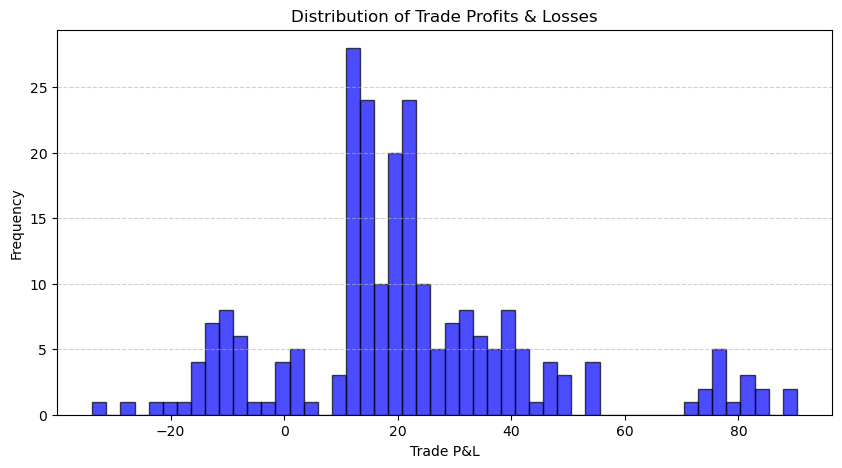

In [22]:
# plot distribution of profits per trades

closed_trades = [trade for trade in e.strategy.trades if trade.role in ['exit', 'cover']]

pnl_list = [trade.pnl for trade in closed_trades]

plt.figure(figsize=(10, 5))
plt.hist(pnl_list, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Trade P&L")
plt.ylabel("Frequency")
plt.title("Distribution of Trade Profits & Losses")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [23]:
closed_trades

[<Trade: 2025-03-01 02:00:00 btc sell 0.011856@84656.93 Role:exit PnL:9.473062559999939>,
 <Trade: 2025-03-01 03:00:00 btc sell 0.00011296000000000049@85240.46 Role:exit PnL:0.1561717184000016>,
 <Trade: 2025-03-01 05:00:00 btc buy 0.01164511@86190.01 Role:cover PnL:-10.529114099915438>,
 <Trade: 2025-03-01 22:00:00 btc buy 0.01166042@86076.86 Role:cover PnL:-11.507745443724879>,
 <Trade: 2025-03-01 23:00:00 btc buy 0.01165507@86116.35 Role:cover PnL:-11.962724207720926>,
 <Trade: 2025-03-02 00:00:00 btc buy 0.01166209@86064.53 Role:cover PnL:-11.36560000804499>,
 <Trade: 2025-03-02 01:00:00 btc buy 0.01166723@86026.62 Role:cover PnL:-10.928304642463198>,
 <Trade: 2025-03-02 04:00:00 btc buy 0.01168809@85873.07 Role:cover PnL:-8.588152532838874>,
 <Trade: 2025-03-02 06:00:00 btc buy 0.01167661@85957.51 Role:cover PnL:-9.058570928834232>,
 <Trade: 2025-03-02 07:00:00 btc buy 0.01163329@86277.65 Role:cover PnL:-12.749245264366495>,
 <Trade: 2025-03-02 08:00:00 btc buy 0.01163939@86232.42

In [24]:
time_label = [trade.idx for trade in closed_trades]
time_label

[Timestamp('2025-03-01 02:00:00'),
 Timestamp('2025-03-01 03:00:00'),
 Timestamp('2025-03-01 05:00:00'),
 Timestamp('2025-03-01 22:00:00'),
 Timestamp('2025-03-01 23:00:00'),
 Timestamp('2025-03-02 00:00:00'),
 Timestamp('2025-03-02 01:00:00'),
 Timestamp('2025-03-02 04:00:00'),
 Timestamp('2025-03-02 06:00:00'),
 Timestamp('2025-03-02 07:00:00'),
 Timestamp('2025-03-02 08:00:00'),
 Timestamp('2025-03-02 10:00:00'),
 Timestamp('2025-03-02 11:00:00'),
 Timestamp('2025-03-02 12:00:00'),
 Timestamp('2025-03-02 13:00:00'),
 Timestamp('2025-03-03 15:00:00'),
 Timestamp('2025-03-03 16:00:00'),
 Timestamp('2025-03-03 17:00:00'),
 Timestamp('2025-03-03 18:00:00'),
 Timestamp('2025-03-03 19:00:00'),
 Timestamp('2025-03-03 20:00:00'),
 Timestamp('2025-03-03 21:00:00'),
 Timestamp('2025-03-03 23:00:00'),
 Timestamp('2025-03-04 00:00:00'),
 Timestamp('2025-03-04 01:00:00'),
 Timestamp('2025-03-04 02:00:00'),
 Timestamp('2025-03-04 03:00:00'),
 Timestamp('2025-03-04 04:00:00'),
 Timestamp('2025-03-

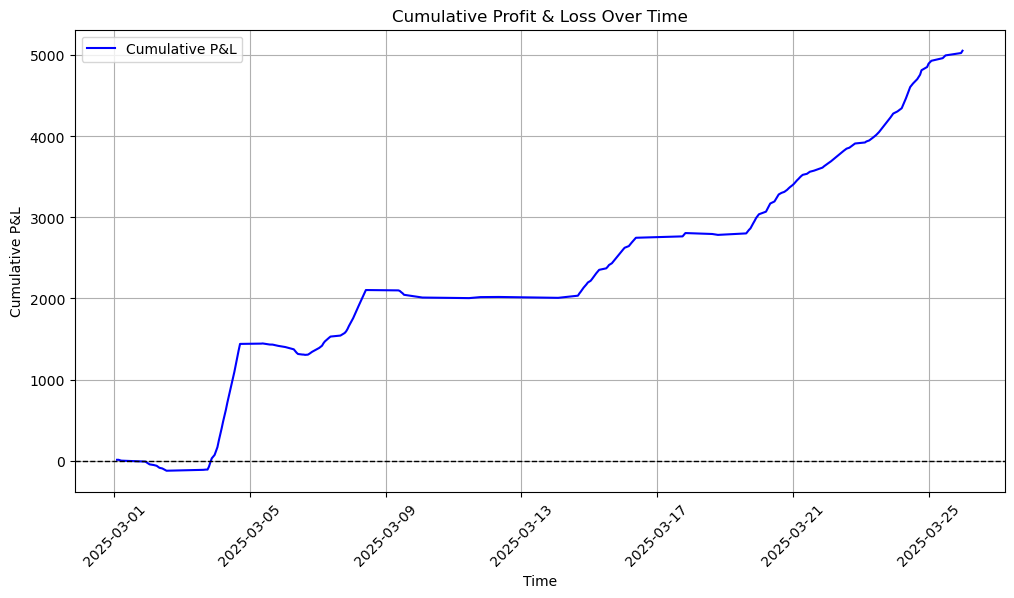

In [25]:
time_label_series = pd.Series(time_label)

# Compute cumulative P&L
cumulative_pnl = np.cumsum(pnl_list)

# Create a DataFrame to align P&L with time labels
pnl_df = pd.DataFrame({'time': time_label_series, 'cumulative_pnl': cumulative_pnl})
pnl_df.set_index('time', inplace=True)  # Set time as index

# Sort by time in case it's out of order
pnl_df.sort_index(inplace=True)

# Plot cumulative P&L over time
plt.figure(figsize=(12, 6))
plt.plot(pnl_df.index, pnl_df['cumulative_pnl'], label="Cumulative P&L", color="blue")
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Baseline at 0
plt.xlabel("Time")
plt.ylabel("Cumulative P&L")
plt.title("Cumulative Profit & Loss Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid()
plt.show()

In [26]:
e.strategy.get_position('btc')

<Position: btc size: 0.7058694000000001 entry: 85370.69928519646>

In [27]:
e.strategy.get_position('btc').size * e.strategy.close()

np.float64(61984.629619998006)

In [28]:
# Define the parameter ranges
initial_cash_values = range(100_000, 750_000, 50_000)  # 100k to 700k in 50k steps
transaction_cost_values = [i/10000 for i in range(10, 101,10)]  # 0.001 to 0.01 (0.1% to 1%)

# Initialize results storage
results = []

# Run backtests for all combinations
for initial_cash in tqdm(initial_cash_values, desc="Initial Cash"):
    row = {}
    for transaction_cost in tqdm(transaction_cost_values, desc=f"Transaction Costs for ${initial_cash:,}", leave=False):
        # Create and run engine
        e = Engine(
            initial_cash=initial_cash,
            transaction_cost=transaction_cost,
            asset_type='cryptocurrencies'
        )
        e.add_data(test_frame)
        e.add_strategy(XGBoostStrategy(
            model=loaded_final_model,
            bet_size=best_params["bet_size"],
            initial_data=initial_test_frame,  # Pass initial data for sequencing
        ))

        stats = e.run()
        
        # Store results
        key = f"{transaction_cost*100:.2f}%"
        row[key] = (
            round(stats['Strategy Sharpe Ratio'], 2),
            round(stats['Buy & Hold Sharpe Ratio'], 2)
        )
    results.append(row)

# Convert results to DataFrame
df_results = pd.DataFrame(
    results,
    index=[f"${x:,}" for x in initial_cash_values]
)

# Display the results table
print("Sharpe Ratios (Strategy, Buy & Hold) for different parameters:")
print(df_results)


Initial Cash:   0%|          | 0/13 [00:00<?, ?it/s]












100%|██████████| 613/613 [00:01<00:00, 450.19it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 44271.001965058626
Final Positions Value: 61984.629619998006 , Final Size: 0.7058694000000001
Final Portfolio Value: 106255.63158505663
Final Portfolio Value: 106255.63158505663
Buy & Hold Final Value: 103897.68086755012
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.51
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades       














100%|██████████| 613/613 [00:01<00:00, 492.34it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 44750.77667649015
Final Positions Value: 60929.27777096249 , Final Size: 0.6938512499999999
Final Portfolio Value: 105680.05444745265
Final Portfolio Value: 105680.05444745265
Buy & Hold Final Value: 103689.78160823825
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         














100%|██████████| 613/613 [00:01<00:00, 465.92it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 44225.85530929451
Final Positions Value: 60916.529933073616 , Final Size: 0.6937060800000002
Final Portfolio Value: 105142.38524236812
Final Portfolio Value: 105142.38524236812
Buy & Hold Final Value: 103482.09056050306
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        














100%|██████████| 613/613 [00:01<00:00, 477.01it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 43700.93377598976
Final Positions Value: 60916.529933073616 , Final Size: 0.6937060800000002
Final Portfolio Value: 104617.46370906338
Final Portfolio Value: 104617.46370906338
Buy & Hold Final Value: 103274.60772434456
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        














100%|██████████| 613/613 [00:01<00:00, 455.18it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 44184.72325779646
Final Positions Value: 59861.178084038074 , Final Size: 0.6816879299999997
Final Portfolio Value: 104045.90134183454
Final Portfolio Value: 104045.90134183454
Buy & Hold Final Value: 103067.33309976272
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        













100%|██████████| 613/613 [00:01<00:00, 463.97it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 43660.805462699085
Final Positions Value: 59854.3242661196 , Final Size: 0.68160988
Final Portfolio Value: 103515.12972881869
Final Portfolio Value: 103515.12972881869
Buy & Hold Final Value: 102860.26668675756
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 
















100%|██████████| 613/613 [00:01<00:00, 414.24it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 43136.88762199232
Final Positions Value: 59854.3242661196 , Final Size: 0.68160988
Final Portfolio Value: 102991.21188811192
Final Portfolio Value: 102991.21188811192
Buy & Hold Final Value: 102653.4084853291
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   















100%|██████████| 613/613 [00:01<00:00, 440.04it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 43624.691874053824
Final Positions Value: 58798.972417084085 , Final Size: 0.6695917299999998
Final Portfolio Value: 102423.66429113792
Final Portfolio Value: 102423.66429113792
Buy & Hold Final Value: 102446.75849547728
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades       














100%|██████████| 613/613 [00:01<00:00, 482.71it/s]


Initial Portfolio Value: 100000
Holding Cash Value: 43101.7777258993
Final Positions Value: 58798.972417084085 , Final Size: 0.6695917299999998
Final Portfolio Value: 101900.7501429834
Final Portfolio Value: 101900.7501429834
Buy & Hold Final Value: 102240.31671720216
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           














Initial Cash:   8%|▊         | 1/13 [00:13<02:41, 13.45s/it]

Initial Portfolio Value: 100000
Holding Cash Value: 43592.59256529932
Final Positions Value: 57724.1699508936 , Final Size: 0.65735208
Final Portfolio Value: 101316.76251619292
Final Portfolio Value: 101316.76251619292
Buy & Hold Final Value: 102034.08315050372
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  















100%|██████████| 613/613 [00:01<00:00, 430.19it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 66406.48051092852
Final Positions Value: 92976.96813955289 , Final Size: 1.0588043699999998
Final Portfolio Value: 159383.4486504814
Final Portfolio Value: 159383.4486504814
Buy & Hold Final Value: 155846.52130132518
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           














100%|██████████| 613/613 [00:01<00:00, 439.48it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 67126.14212429452
Final Positions Value: 91393.94080506549 , Final Size: 1.0407771499999998
Final Portfolio Value: 158520.08292936
Final Portfolio Value: 158520.08292936
Buy & Hold Final Value: 155534.67241235738
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               













100%|██████████| 613/613 [00:01<00:00, 492.88it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 66338.76045653729
Final Positions Value: 91374.81860916628 , Final Size: 1.0405593899999999
Final Portfolio Value: 157713.57906570355
Final Portfolio Value: 157713.57906570355
Buy & Hold Final Value: 155223.1358407546
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          














100%|██████████| 613/613 [00:01<00:00, 471.77it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 65551.37812120769
Final Positions Value: 91374.81860916628 , Final Size: 1.0405593899999999
Final Portfolio Value: 156926.19673037395
Final Portfolio Value: 156926.19673037395
Buy & Hold Final Value: 154911.91158651683
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         













100%|██████████| 613/613 [00:01<00:00, 496.09it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 66277.06188888413
Final Positions Value: 89791.79127467888 , Final Size: 1.0225321699999999
Final Portfolio Value: 156068.853163563
Final Portfolio Value: 156068.853163563
Buy & Hold Final Value: 154600.9996496441
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              













100%|██████████| 613/613 [00:01<00:00, 506.83it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 65491.18558052695
Final Positions Value: 89781.5101087353 , Final Size: 1.02241509
Final Portfolio Value: 155272.69568926224
Final Portfolio Value: 155272.69568926224
Buy & Hold Final Value: 154290.40003013637
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                  













100%|██████████| 613/613 [00:01<00:00, 504.25it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 64705.308784094224
Final Positions Value: 89781.5101087353 , Final Size: 1.02241509
Final Portfolio Value: 154486.81889282953
Final Portfolio Value: 154486.81889282953
Buy & Hold Final Value: 153980.11272799363
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                 














100%|██████████| 613/613 [00:01<00:00, 479.04it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 65437.01470589966
Final Positions Value: 88198.48277424788 , Final Size: 1.0043878699999997
Final Portfolio Value: 153635.49748014755
Final Portfolio Value: 153635.49748014755
Buy & Hold Final Value: 153670.13774321595
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         














100%|██████████| 613/613 [00:01<00:00, 490.32it/s]


Initial Portfolio Value: 150000
Holding Cash Value: 64652.643447878065
Final Positions Value: 88198.48277424788 , Final Size: 1.0043878699999997
Final Portfolio Value: 152851.12622212595
Final Portfolio Value: 152851.12622212595
Buy & Hold Final Value: 153360.47507580326
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        














Initial Cash:  15%|█▌        | 2/13 [00:26<02:25, 13.20s/it]

Initial Portfolio Value: 150000
Holding Cash Value: 65388.866924341426
Final Positions Value: 86586.27775776459 , Final Size: 0.9860283799999999
Final Portfolio Value: 151975.144682106
Final Portfolio Value: 151975.144682106
Buy & Hold Final Value: 153051.12472575557
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 413.60it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 88541.97558593517
Final Positions Value: 123969.28909647372 , Final Size: 1.411739139999999
Final Portfolio Value: 212511.2646824089
Final Portfolio Value: 212511.2646824089
Buy & Hold Final Value: 207795.36173510025
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 443.93it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 89501.5249838166
Final Positions Value: 121858.58539840273 , Final Size: 1.3877028399999993
Final Portfolio Value: 211360.11038221934
Final Portfolio Value: 211360.11038221934
Buy & Hold Final Value: 207379.5632164765
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          















100%|██████████| 613/613 [00:01<00:00, 425.64it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 88451.68139678818
Final Positions Value: 121833.09060075661 , Final Size: 1.387412509999999
Final Portfolio Value: 210284.7719975448
Final Portfolio Value: 210284.7719975448
Buy & Hold Final Value: 206964.1811210061
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            
















100%|██████████| 613/613 [00:01<00:00, 383.85it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 87401.8383043719
Final Positions Value: 121833.09060075661 , Final Size: 1.387412509999999
Final Portfolio Value: 209234.9289051285
Final Portfolio Value: 209234.9289051285
Buy & Hold Final Value: 206549.21544868912
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            
















100%|██████████| 613/613 [00:01<00:00, 391.39it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 88369.41724217874
Final Positions Value: 119722.38690268555 , Final Size: 1.3633762099999984
Final Portfolio Value: 208091.8041448643
Final Portfolio Value: 208091.8041448643
Buy & Hold Final Value: 206134.66619952544
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          















100%|██████████| 613/613 [00:01<00:00, 430.72it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 87321.58162617683
Final Positions Value: 119708.6792668486 , Final Size: 1.363220109999999
Final Portfolio Value: 207030.26089302544
Final Portfolio Value: 207030.26089302544
Buy & Hold Final Value: 205720.53337351512
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          















100%|██████████| 613/613 [00:01<00:00, 417.07it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 86273.74591895664
Final Positions Value: 119708.6792668486 , Final Size: 1.363220109999999
Final Portfolio Value: 205982.42518580524
Final Portfolio Value: 205982.42518580524
Buy & Hold Final Value: 205306.8169706582
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 436.43it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 87249.35439727275
Final Positions Value: 117597.9755687776 , Final Size: 1.3391838099999989
Final Portfolio Value: 204847.32996605034
Final Portfolio Value: 204847.32996605034
Buy & Hold Final Value: 204893.51699095455
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 422.38it/s]


Initial Portfolio Value: 200000
Holding Cash Value: 86203.52607515684
Final Positions Value: 117597.9755687776 , Final Size: 1.3391838099999989
Final Portfolio Value: 203801.50164393446
Final Portfolio Value: 203801.50164393446
Buy & Hold Final Value: 204480.63343440433
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















Initial Cash:  23%|██▎       | 3/13 [00:41<02:19, 13.91s/it]

Initial Portfolio Value: 200000
Holding Cash Value: 87185.1565595537
Final Positions Value: 115448.36975826487 , Final Size: 1.3147044999999986
Final Portfolio Value: 202633.52631781856
Final Portfolio Value: 202633.52631781856
Buy & Hold Final Value: 204068.16630100744
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 423.57it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 110677.472210017
Final Positions Value: 154961.6082971315 , Final Size: 1.7646738900000023
Final Portfolio Value: 265639.0805071485
Final Portfolio Value: 265639.0805071485
Buy & Hold Final Value: 259744.20216887526
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            














100%|██████████| 613/613 [00:01<00:00, 463.82it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 111876.90854272315
Final Positions Value: 152323.22911360857 , Final Size: 1.734628520000002
Final Portfolio Value: 264200.1376563317
Final Portfolio Value: 264200.1376563317
Buy & Hold Final Value: 259224.45402059561
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          














100%|██████████| 613/613 [00:01<00:00, 453.72it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 110564.60468802309
Final Positions Value: 152291.3599579521 , Final Size: 1.7342656000000014
Final Portfolio Value: 262855.9646459752
Final Portfolio Value: 262855.9646459752
Buy & Hold Final Value: 258705.22640125765
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          














100%|██████████| 613/613 [00:01<00:00, 459.87it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 109252.30082647211
Final Positions Value: 152291.3599579521 , Final Size: 1.7342656000000014
Final Portfolio Value: 261543.66078442422
Final Portfolio Value: 261543.66078442422
Buy & Hold Final Value: 258186.5193108614
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 425.41it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 110461.77408303843
Final Positions Value: 149652.98077442922 , Final Size: 1.7042202300000016
Final Portfolio Value: 260114.75485746766
Final Portfolio Value: 260114.75485746766
Buy & Hold Final Value: 257668.33274940684
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades       















100%|██████████| 613/613 [00:01<00:00, 430.26it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 109151.97998666743
Final Positions Value: 149635.84579056714 , Final Size: 1.7040251000000017
Final Portfolio Value: 258787.82577723457
Final Portfolio Value: 258787.82577723457
Buy & Hold Final Value: 257150.6667168939
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        
















100%|██████████| 613/613 [00:01<00:00, 401.97it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 107842.1853566105
Final Positions Value: 149635.84579056714 , Final Size: 1.7040251000000017
Final Portfolio Value: 257478.03114717762
Final Portfolio Value: 257478.03114717762
Buy & Hold Final Value: 256633.5212133227
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 438.61it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 109061.69553756116
Final Positions Value: 146997.46660704428 , Final Size: 1.6739797300000019
Final Portfolio Value: 256059.16214460542
Final Portfolio Value: 256059.16214460542
Buy & Hold Final Value: 256116.89623869324
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades       















100%|██████████| 613/613 [00:01<00:00, 424.07it/s]


Initial Portfolio Value: 250000
Holding Cash Value: 107754.41013846853
Final Positions Value: 146997.46660704428 , Final Size: 1.6739797300000019
Final Portfolio Value: 254751.87674551283
Final Portfolio Value: 254751.87674551283
Buy & Hold Final Value: 255600.79179300542
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades       















Initial Cash:  31%|███       | 4/13 [00:55<02:06, 14.06s/it]

Initial Portfolio Value: 250000
Holding Cash Value: 108981.44846141513
Final Positions Value: 144310.45912437042 , Final Size: 1.6433805900000014
Final Portfolio Value: 253291.90758578555
Final Portfolio Value: 253291.90758578555
Buy & Hold Final Value: 255085.2078762593
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        
















100%|██████████| 613/613 [00:01<00:00, 404.43it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 132812.97842577955
Final Positions Value: 185953.91783834 , Final Size: 2.117608529999999
Final Portfolio Value: 318766.89626411954
Final Portfolio Value: 318766.89626411954
Buy & Hold Final Value: 311693.04260265036
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.51
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           
















100%|██████████| 613/613 [00:01<00:00, 410.10it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 134252.30252378038
Final Positions Value: 182787.8622912335 , Final Size: 2.0815540799999988
Final Portfolio Value: 317040.1648150139
Final Portfolio Value: 317040.1648150139
Buy & Hold Final Value: 311069.34482471476
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          
















100%|██████████| 613/613 [00:01<00:00, 382.04it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 132677.5375582447
Final Positions Value: 182749.61965569848 , Final Size: 2.0811185799999987
Final Portfolio Value: 315427.1572139432
Final Portfolio Value: 315427.1572139432
Buy & Hold Final Value: 310446.2716815092
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           
















100%|██████████| 613/613 [00:01<00:00, 387.06it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 131102.77292121184
Final Positions Value: 182749.61965569848 , Final Size: 2.0811185799999987
Final Portfolio Value: 313852.3925769103
Final Portfolio Value: 313852.3925769103
Buy & Hold Final Value: 309823.82317303366
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 421.58it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 132554.14132951366
Final Positions Value: 179583.564108592 , Final Size: 2.0450641299999988
Final Portfolio Value: 312137.7054381056
Final Portfolio Value: 312137.7054381056
Buy & Hold Final Value: 309201.9992992882
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 420.80it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 130982.38790710195
Final Positions Value: 179563.0026548365 , Final Size: 2.044829979999999
Final Portfolio Value: 310545.39056193846
Final Portfolio Value: 310545.39056193846
Buy & Hold Final Value: 308580.80006027274
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 417.03it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 129410.63434786287
Final Positions Value: 179563.0026548365 , Final Size: 2.044829979999999
Final Portfolio Value: 308973.63700269937
Final Portfolio Value: 308973.63700269937
Buy & Hold Final Value: 307960.22545598727
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 412.46it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 130874.04706692831
Final Positions Value: 176396.94710773 , Final Size: 2.008775529999999
Final Portfolio Value: 307270.9941746583
Final Portfolio Value: 307270.9941746583
Buy & Hold Final Value: 307340.2754864319
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              
















100%|██████████| 613/613 [00:01<00:00, 406.03it/s]


Initial Portfolio Value: 300000
Holding Cash Value: 129305.30458534612
Final Positions Value: 176396.94710773 , Final Size: 2.008775529999999
Final Portfolio Value: 305702.2516930761
Final Portfolio Value: 305702.2516930761
Buy & Hold Final Value: 306720.9501516065
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              















Initial Cash:  38%|███▊      | 5/13 [01:10<01:55, 14.46s/it]

Initial Portfolio Value: 300000
Holding Cash Value: 130777.74989783164
Final Positions Value: 173172.53883102685 , Final Size: 1.9720565699999995
Final Portfolio Value: 303950.28872885846
Final Portfolio Value: 303950.28872885846
Buy & Hold Final Value: 306102.24945151113
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades       















100%|██████████| 613/613 [00:01<00:00, 442.68it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 154948.46464518574
Final Positions Value: 216946.24845470965 , Final Size: 2.4705434099999994
Final Portfolio Value: 371894.7130998954
Final Portfolio Value: 371894.7130998954
Buy & Hold Final Value: 363641.8830364254
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          















100%|██████████| 613/613 [00:01<00:00, 420.52it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 156627.67566821596
Final Positions Value: 213252.5174221512 , Final Size: 2.428479889999999
Final Portfolio Value: 369880.19309036713
Final Portfolio Value: 369880.19309036713
Buy & Hold Final Value: 362914.2356288339
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          
















100%|██████████| 613/613 [00:01<00:00, 384.99it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 154790.4504252125
Final Positions Value: 213207.9004286058 , Final Size: 2.4279717999999977
Final Portfolio Value: 367998.3508538183
Final Portfolio Value: 367998.3508538183
Buy & Hold Final Value: 362187.31696176075
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 413.06it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 152953.22500925045
Final Positions Value: 213207.9004286058 , Final Size: 2.4279717999999977
Final Portfolio Value: 366161.12543785624
Final Portfolio Value: 366161.12543785624
Buy & Hold Final Value: 361461.12703520595
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        
















100%|██████████| 613/613 [00:01<00:00, 384.22it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 154646.487726516
Final Positions Value: 209514.16939604742 , Final Size: 2.385908279999998
Final Portfolio Value: 364160.65712256345
Final Portfolio Value: 364160.65712256345
Buy & Hold Final Value: 360735.6658491695
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 400.55it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 152812.77581393952
Final Positions Value: 209490.18059426683 , Final Size: 2.3856350999999982
Final Portfolio Value: 362302.9564082064
Final Portfolio Value: 362302.9564082064
Buy & Hold Final Value: 360010.9334036515
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          

















100%|██████████| 613/613 [00:01<00:00, 347.70it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 150979.06332206895
Final Positions Value: 209490.18059426683 , Final Size: 2.3856350999999982
Final Portfolio Value: 360469.24391633575
Final Portfolio Value: 360469.24391633575
Buy & Hold Final Value: 359286.9296986519
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        















100%|██████████| 613/613 [00:01<00:00, 447.00it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 152686.37773397303
Final Positions Value: 205796.4495617084 , Final Size: 2.3435715799999977
Final Portfolio Value: 358482.82729568146
Final Portfolio Value: 358482.82729568146
Buy & Hold Final Value: 358563.6547341705
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 416.05it/s]


Initial Portfolio Value: 350000
Holding Cash Value: 150856.178165618
Final Positions Value: 205796.4495617084 , Final Size: 2.3435715799999977
Final Portfolio Value: 356652.6277273264
Final Portfolio Value: 356652.6277273264
Buy & Hold Final Value: 357841.10851020756
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















Initial Cash:  46%|████▌     | 6/13 [01:25<01:43, 14.72s/it]

Initial Portfolio Value: 350000
Holding Cash Value: 152574.032138262
Final Positions Value: 202034.63873471232 , Final Size: 2.300732779999997
Final Portfolio Value: 354608.6708729743
Final Portfolio Value: 354608.6708729743
Buy & Hold Final Value: 357119.291026763
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              















100%|██████████| 613/613 [00:01<00:00, 429.54it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 177083.94501921494
Final Positions Value: 247938.58433986947 , Final Size: 2.82347835
Final Portfolio Value: 425022.52935908444
Final Portfolio Value: 425022.52935908444
Buy & Hold Final Value: 415590.7234702005
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                















100%|██████████| 613/613 [00:01<00:00, 426.66it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 179003.04379771184
Final Positions Value: 243717.17694372733 , Final Size: 2.7754057499999982
Final Portfolio Value: 422720.22074143915
Final Portfolio Value: 422720.22074143915
Buy & Hold Final Value: 414759.126432953
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 442.05it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 176903.3574340433
Final Positions Value: 243666.18647030345 , Final Size: 2.7748250799999985
Final Portfolio Value: 420569.54390434676
Final Portfolio Value: 420569.54390434676
Buy & Hold Final Value: 413928.3622420122
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 424.27it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 174803.67123277043
Final Positions Value: 243666.18647030345 , Final Size: 2.7748250799999985
Final Portfolio Value: 418469.8577030739
Final Portfolio Value: 418469.8577030739
Buy & Hold Final Value: 413098.43089737825
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 433.82it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 176738.8290919426
Final Positions Value: 239444.77907416143 , Final Size: 2.7267524799999983
Final Portfolio Value: 416183.60816610407
Final Portfolio Value: 416183.60816610407
Buy & Hold Final Value: 412269.3323990509
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 425.56it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 174643.15784349773
Final Positions Value: 239417.36380248747 , Final Size: 2.7264402799999985
Final Portfolio Value: 414060.5216459852
Final Portfolio Value: 414060.5216459852
Buy & Hold Final Value: 411441.06674703024
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 410.11it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 172547.48641261552
Final Positions Value: 239417.36380248747 , Final Size: 2.7264402799999985
Final Portfolio Value: 411964.850215103
Final Portfolio Value: 411964.850215103
Buy & Hold Final Value: 410613.6339413164
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 428.99it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 174498.70335280662
Final Positions Value: 235195.95640634542 , Final Size: 2.678367679999998
Final Portfolio Value: 409694.65975915204
Final Portfolio Value: 409694.65975915204
Buy & Hold Final Value: 409787.0339819091
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 423.65it/s]


Initial Portfolio Value: 400000
Holding Cash Value: 172407.04669213374
Final Positions Value: 235195.95640634542 , Final Size: 2.678367679999998
Final Portfolio Value: 407603.0030984791
Final Portfolio Value: 407603.0030984791
Buy & Hold Final Value: 408961.26686880866
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          















Initial Cash:  54%|█████▍    | 7/13 [01:40<01:27, 14.63s/it]

Initial Portfolio Value: 400000
Holding Cash Value: 174370.30764448672
Final Positions Value: 230896.74478531998 , Final Size: 2.6294090599999977
Final Portfolio Value: 405267.0524298067
Final Portfolio Value: 405267.0524298067
Buy & Hold Final Value: 408136.3326020149
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          















100%|██████████| 613/613 [00:01<00:00, 453.54it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 199219.4563544239
Final Positions Value: 278930.8886122878 , Final Size: 3.176412929999997
Final Portfolio Value: 478150.3449667117
Final Portfolio Value: 478150.3449667117
Buy & Hold Final Value: 467539.5639039754
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             















100%|██████████| 613/613 [00:01<00:00, 435.55it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 201378.4420737831
Final Positions Value: 274181.8057306938 , Final Size: 3.1223312599999957
Final Portfolio Value: 475560.2478044769
Final Portfolio Value: 475560.2478044769
Buy & Hold Final Value: 466604.0172370721
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 419.99it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 199016.29544848073
Final Positions Value: 274124.44089925964 , Final Size: 3.1216779999999957
Final Portfolio Value: 473140.7363477404
Final Portfolio Value: 473140.7363477404
Buy & Hold Final Value: 465669.40752226376
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         

















100%|██████████| 613/613 [00:01<00:00, 360.85it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 196654.14848411098
Final Positions Value: 274124.44089925964 , Final Size: 3.1216779999999957
Final Portfolio Value: 470778.5893833706
Final Portfolio Value: 470778.5893833706
Buy & Hold Final Value: 464735.7347595505
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          

















100%|██████████| 613/613 [00:01<00:00, 391.63it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 198831.20066807998
Final Positions Value: 269375.35801766574 , Final Size: 3.067596329999996
Final Portfolio Value: 468206.5586857457
Final Portfolio Value: 468206.5586857457
Buy & Hold Final Value: 463802.9989489322
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           

















100%|██████████| 613/613 [00:01<00:00, 389.32it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 196473.57011056595
Final Positions Value: 269344.5162760983 , Final Size: 3.0672451099999956
Final Portfolio Value: 465818.0863866643
Final Portfolio Value: 465818.0863866643
Buy & Hold Final Value: 462871.200090409
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            

















100%|██████████| 613/613 [00:01<00:00, 376.11it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 194115.9397620558
Final Positions Value: 269344.5162760983 , Final Size: 3.0672451099999956
Final Portfolio Value: 463460.4560381541
Final Portfolio Value: 463460.4560381541
Buy & Hold Final Value: 461940.3381839809
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            
















100%|██████████| 613/613 [00:01<00:00, 395.49it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 196311.0584100884
Final Positions Value: 264595.43339450436 , Final Size: 3.013163439999995
Final Portfolio Value: 460906.4918045928
Final Portfolio Value: 460906.4918045928
Buy & Hold Final Value: 461010.41322964785
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           
















100%|██████████| 613/613 [00:01<00:00, 406.77it/s]


Initial Portfolio Value: 450000
Holding Cash Value: 193957.94467764682
Final Positions Value: 264595.43339450436 , Final Size: 3.013163439999995
Final Portfolio Value: 458553.3780721512
Final Portfolio Value: 458553.3780721512
Buy & Hold Final Value: 460081.4252274097
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           
















Initial Cash:  62%|██████▏   | 8/13 [01:55<01:14, 14.88s/it]

Initial Portfolio Value: 450000
Holding Cash Value: 196166.61347375737
Final Positions Value: 259758.82010131795 , Final Size: 2.958084989999996
Final Portfolio Value: 455925.43357507535
Final Portfolio Value: 455925.43357507535
Buy & Hold Final Value: 459153.3741772667
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         


















100%|██████████| 613/613 [00:01<00:00, 338.47it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 221354.9369312959
Final Positions Value: 309923.22449744813 , Final Size: 3.5293478700000027
Final Portfolio Value: 531278.161428744
Final Portfolio Value: 531278.161428744
Buy & Hold Final Value: 519488.4043377505
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             
















100%|██████████| 613/613 [00:01<00:00, 386.03it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 223753.81042366457
Final Positions Value: 304646.4652522706 , Final Size: 3.469257120000002
Final Portfolio Value: 528400.2756759352
Final Portfolio Value: 528400.2756759352
Buy & Hold Final Value: 518448.90804119123
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           
















100%|██████████| 613/613 [00:01<00:00, 403.40it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 221129.2026952399
Final Positions Value: 304582.72694095783 , Final Size: 3.4685312800000028
Final Portfolio Value: 525711.9296361977
Final Portfolio Value: 525711.9296361977
Buy & Hold Final Value: 517410.4528025153
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           














100%|██████████| 613/613 [00:01<00:00, 481.76it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 218504.5949631016
Final Positions Value: 304582.72694095783 , Final Size: 3.4685312800000028
Final Portfolio Value: 523087.32190405944
Final Portfolio Value: 523087.32190405944
Buy & Hold Final Value: 516373.0386217228
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         














100%|██████████| 613/613 [00:01<00:00, 479.39it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 220923.54230652156
Final Positions Value: 299305.9676957802 , Final Size: 3.4084405300000014
Final Portfolio Value: 520229.5100023018
Final Portfolio Value: 520229.5100023018
Buy & Hold Final Value: 515336.6654988137
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 444.38it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 218303.9524306819
Final Positions Value: 299271.6994843194 , Final Size: 3.4080502900000016
Final Portfolio Value: 517575.65191500133
Final Portfolio Value: 517575.65191500133
Buy & Hold Final Value: 514301.3334337878
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          















100%|██████████| 613/613 [00:01<00:00, 455.31it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 215684.36316070292
Final Positions Value: 299271.6994843194 , Final Size: 3.4080502900000016
Final Portfolio Value: 514956.06264502235
Final Portfolio Value: 514956.06264502235
Buy & Hold Final Value: 513267.0424266454
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         















100%|██████████| 613/613 [00:01<00:00, 451.90it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 218123.38435456593
Final Positions Value: 293994.94023914187 , Final Size: 3.347959540000001
Final Portfolio Value: 512118.3245937078
Final Portfolio Value: 512118.3245937078
Buy & Hold Final Value: 512233.7924773865
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 430.06it/s]


Initial Portfolio Value: 500000
Holding Cash Value: 215508.8135473495
Final Positions Value: 293994.94023914187 , Final Size: 3.347959540000001
Final Portfolio Value: 509503.75378649135
Final Portfolio Value: 509503.75378649135
Buy & Hold Final Value: 511201.58358601085
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades         
















Initial Cash:  69%|██████▉   | 9/13 [02:10<00:59, 14.80s/it]

Initial Portfolio Value: 500000
Holding Cash Value: 217962.88934071266
Final Positions Value: 288620.92615192605 , Final Size: 3.2867612700000017
Final Portfolio Value: 506583.81549263874
Final Portfolio Value: 506583.81549263874
Buy & Hold Final Value: 510170.4157525186
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades        















100%|██████████| 613/613 [00:01<00:00, 442.21it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 243490.43225982485
Final Positions Value: 340915.54545436904 , Final Size: 3.882282640000003
Final Portfolio Value: 584405.9777141939
Final Portfolio Value: 584405.9777141939
Buy & Hold Final Value: 571437.2447715256
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 433.55it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 246129.19267447732
Final Positions Value: 335111.11072373966 , Final Size: 3.816182820000003
Final Portfolio Value: 581240.303398217
Final Portfolio Value: 581240.303398217
Buy & Hold Final Value: 570293.7988453103
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             















100%|██████████| 613/613 [00:01<00:00, 430.87it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 243242.12466584332
Final Positions Value: 335040.99805441656 , Final Size: 3.8153843900000033
Final Portfolio Value: 578283.1227202599
Final Portfolio Value: 578283.1227202599
Buy & Hold Final Value: 569151.4980827669
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          














100%|██████████| 613/613 [00:01<00:00, 450.40it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 240355.05615203097
Final Positions Value: 335040.99805441656 , Final Size: 3.8153843900000033
Final Portfolio Value: 575396.0542064476
Final Portfolio Value: 575396.0542064476
Buy & Hold Final Value: 568010.3424838951
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          














100%|██████████| 613/613 [00:01<00:00, 459.79it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 243015.89780166926
Final Positions Value: 329236.5633237872 , Final Size: 3.7492845700000035
Final Portfolio Value: 572252.4611254565
Final Portfolio Value: 572252.4611254565
Buy & Hold Final Value: 566870.332048695
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 455.77it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 240134.34943292048
Final Positions Value: 329198.8677643012 , Final Size: 3.748855300000002
Final Portfolio Value: 569333.2171972217
Final Portfolio Value: 569333.2171972217
Buy & Hold Final Value: 565731.4667771666
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 418.15it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 237252.80122756588
Final Positions Value: 329198.8677643012 , Final Size: 3.748855300000002
Final Portfolio Value: 566451.6689918671
Final Portfolio Value: 566451.6689918671
Buy & Hold Final Value: 564593.74666931
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              















100%|██████████| 613/613 [00:01<00:00, 447.28it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 239935.72411152237
Final Positions Value: 323394.4330336718 , Final Size: 3.682755480000002
Final Portfolio Value: 563330.1571451942
Final Portfolio Value: 563330.1571451942
Buy & Hold Final Value: 563457.171725125
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             















100%|██████████| 613/613 [00:01<00:00, 441.28it/s]


Initial Portfolio Value: 550000
Holding Cash Value: 237059.6962147891
Final Positions Value: 323394.4330336718 , Final Size: 3.682755480000002
Final Portfolio Value: 560454.1292484609
Final Portfolio Value: 560454.1292484609
Buy & Hold Final Value: 562321.7419446119
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             














Initial Cash:  77%|███████▋  | 10/13 [02:24<00:43, 14.54s/it]

Initial Portfolio Value: 550000
Holding Cash Value: 239759.18066556723
Final Positions Value: 317483.01639616303 , Final Size: 3.6154373700000018
Final Portfolio Value: 557242.1970617303
Final Portfolio Value: 557242.1970617303
Buy & Hold Final Value: 561187.4573277705
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades          















100%|██████████| 613/613 [00:01<00:00, 443.73it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 265625.9178102003
Final Positions Value: 371907.8760707381 , Final Size: 4.235217519999996
Final Portfolio Value: 637533.7938809383
Final Portfolio Value: 637533.7938809383
Buy & Hold Final Value: 623386.0852053007
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             














100%|██████████| 613/613 [00:01<00:00, 462.36it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 268504.5659940879
Final Positions Value: 365575.764976525 , Final Size: 4.163108619999996
Final Portfolio Value: 634080.3309706128
Final Portfolio Value: 634080.3309706128
Buy & Hold Final Value: 622138.6896494295
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              















100%|██████████| 613/613 [00:01<00:00, 449.53it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 265355.03605090256
Final Positions Value: 365499.279705455 , Final Size: 4.1622376199999955
Final Portfolio Value: 630854.3157563575
Final Portfolio Value: 630854.3157563575
Buy & Hold Final Value: 620892.5433630184
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 448.03it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 262205.50676472246
Final Positions Value: 365499.279705455 , Final Size: 4.1622376199999955
Final Portfolio Value: 627704.7864701775
Final Portfolio Value: 627704.7864701775
Buy & Hold Final Value: 619647.6463460673
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 454.39it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 265108.2435692119
Final Positions Value: 359167.1686112421 , Final Size: 4.0901287199999965
Final Portfolio Value: 624275.412180454
Final Portfolio Value: 624275.412180454
Buy & Hold Final Value: 618403.9985985764
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              















100%|██████████| 613/613 [00:01<00:00, 450.43it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 261964.73587753775
Final Positions Value: 359126.0465818629 , Final Size: 4.089660429999998
Final Portfolio Value: 621090.7824594006
Final Portfolio Value: 621090.7824594006
Buy & Hold Final Value: 617161.6001205455
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            














100%|██████████| 613/613 [00:01<00:00, 462.61it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 258821.22874611596
Final Positions Value: 359126.0465818629 , Final Size: 4.089660429999998
Final Portfolio Value: 617947.2753279789
Final Portfolio Value: 617947.2753279789
Buy & Hold Final Value: 615920.4509119745
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 455.68it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 261748.05417130337
Final Positions Value: 352793.93548764987 , Final Size: 4.017551529999998
Final Portfolio Value: 614541.9896589533
Final Portfolio Value: 614541.9896589533
Buy & Hold Final Value: 614680.5509728638
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 444.98it/s]


Initial Portfolio Value: 600000
Holding Cash Value: 258610.56919519565
Final Positions Value: 352793.93548764987 , Final Size: 4.017551529999998
Final Portfolio Value: 611404.5046828456
Final Portfolio Value: 611404.5046828456
Buy & Hold Final Value: 613441.900303213
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















Initial Cash:  85%|████████▍ | 11/13 [02:38<00:28, 14.30s/it]

Initial Portfolio Value: 600000
Holding Cash Value: 261555.4606386263
Final Positions Value: 346345.11805611185 , Final Size: 3.9441135999999983
Final Portfolio Value: 607900.5786947382
Final Portfolio Value: 607900.5786947382
Buy & Hold Final Value: 612204.4989030223
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           














100%|██████████| 613/613 [00:01<00:00, 465.94it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 287761.41292703524
Final Positions Value: 402900.19702765875 , Final Size: 4.588152289999994
Final Portfolio Value: 690661.609954694
Final Portfolio Value: 690661.609954694
Buy & Hold Final Value: 675334.9256390756
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             















100%|██████████| 613/613 [00:01<00:00, 412.88it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 290879.9480334078
Final Positions Value: 396040.4104479939 , Final Size: 4.510034319999995
Final Portfolio Value: 686920.3584814017
Final Portfolio Value: 686920.3584814017
Buy & Hold Final Value: 673983.5804535486
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             















100%|██████████| 613/613 [00:01<00:00, 437.04it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 287467.957810212
Final Positions Value: 395957.55081891373 , Final Size: 4.509090729999996
Final Portfolio Value: 683425.5086291258
Final Portfolio Value: 683425.5086291258
Buy & Hold Final Value: 672633.58864327
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades               















100%|██████████| 613/613 [00:01<00:00, 429.96it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 284055.96774255944
Final Positions Value: 395957.55081891373 , Final Size: 4.509090729999996
Final Portfolio Value: 680013.5185614731
Final Portfolio Value: 680013.5185614731
Buy & Hold Final Value: 671284.9502082396
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 446.67it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 287200.5988534701
Final Positions Value: 389097.76423924876 , Final Size: 4.430972759999995
Final Portfolio Value: 676298.3630927189
Final Portfolio Value: 676298.3630927189
Buy & Hold Final Value: 669937.6651484576
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            














100%|██████████| 613/613 [00:01<00:00, 455.07it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 283795.1326690883
Final Positions Value: 389053.2148618445 , Final Size: 4.430465439999996
Final Portfolio Value: 672848.3475309329
Final Portfolio Value: 672848.3475309329
Buy & Hold Final Value: 668591.7334639243
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             















100%|██████████| 613/613 [00:01<00:00, 435.02it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 280389.6666024914
Final Positions Value: 389053.2148618445 , Final Size: 4.430465439999996
Final Portfolio Value: 669442.8814643358
Final Portfolio Value: 669442.8814643358
Buy & Hold Final Value: 667247.155154639
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              















100%|██████████| 613/613 [00:01<00:00, 432.60it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 283560.39371797483
Final Positions Value: 382193.42828217946 , Final Size: 4.352347469999995
Final Portfolio Value: 665753.8220001543
Final Portfolio Value: 665753.8220001543
Buy & Hold Final Value: 665903.9302206023
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades           















100%|██████████| 613/613 [00:01<00:00, 444.23it/s]


Initial Portfolio Value: 650000
Holding Cash Value: 280161.4516525486
Final Positions Value: 382193.42828217946 , Final Size: 4.352347469999995
Final Portfolio Value: 662354.8799347281
Final Portfolio Value: 662354.8799347281
Buy & Hold Final Value: 664562.0586618141
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















Initial Cash:  92%|█████████▏| 12/13 [02:52<00:14, 14.25s/it]

Initial Portfolio Value: 650000
Holding Cash Value: 283351.7509221911
Final Positions Value: 375207.2091784802 , Final Size: 4.272789709999994
Final Portfolio Value: 658558.9601006713
Final Portfolio Value: 658558.9601006713
Buy & Hold Final Value: 663221.5404782741
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             















100%|██████████| 613/613 [00:01<00:00, 451.76it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 309896.9088795509
Final Positions Value: 433892.51710644853 , Final Size: 4.94108705
Final Portfolio Value: 743789.4259859994
Final Portfolio Value: 743789.4259859994
Buy & Hold Final Value: 727283.7660728508
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       6.26
Buy-and-Hold Total Return (%)            |       3.90
Average Exposure to Asset (%)            |      44.33
Strategy CAGR (%)                        |     142.52
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      22.55
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.50
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades                   















100%|██████████| 613/613 [00:01<00:00, 438.10it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 313255.3317595435
Final Positions Value: 426505.05416320014 , Final Size: 4.856960000000002
Final Portfolio Value: 739760.3859227437
Final Portfolio Value: 739760.3859227437
Buy & Hold Final Value: 725828.4712576678
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.68
Buy-and-Hold Total Return (%)            |       3.69
Average Exposure to Asset (%)            |      44.15
Strategy CAGR (%)                        |     124.03
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.31
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      19.64
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 446.69it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 309580.8804338344
Final Positions Value: 426415.821054241 , Final Size: 4.855943829999998
Final Portfolio Value: 735996.7014880753
Final Portfolio Value: 735996.7014880753
Buy & Hold Final Value: 724374.6339235215
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       5.14
Buy-and-Hold Total Return (%)            |       3.48
Average Exposure to Asset (%)            |      44.16
Strategy CAGR (%)                        |     107.95
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.32
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      17.09
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.54
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              















100%|██████████| 613/613 [00:01<00:00, 438.54it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 305906.4295990237
Final Positions Value: 426415.821054241 , Final Size: 4.855943829999998
Final Portfolio Value: 732322.2506532647
Final Portfolio Value: 732322.2506532647
Buy & Hold Final Value: 722922.2540704119
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.62
Buy-and-Hold Total Return (%)            |       3.27
Average Exposure to Asset (%)            |      44.32
Strategy CAGR (%)                        |      93.30
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      14.73
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.57
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              















100%|██████████| 613/613 [00:01<00:00, 449.01it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 309292.95586999325
Final Positions Value: 419028.3581109925 , Final Size: 4.771816779999999
Final Portfolio Value: 728321.3139809858
Final Portfolio Value: 728321.3139809858
Buy & Hold Final Value: 721471.331698339
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       4.05
Buy-and-Hold Total Return (%)            |       3.07
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      78.44
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      12.40
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.61
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             














100%|██████████| 613/613 [00:01<00:00, 460.16it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 305625.53036789503
Final Positions Value: 418980.3822636947 , Final Size: 4.7712704399999994
Final Portfolio Value: 724605.9126315897
Final Portfolio Value: 724605.9126315897
Buy & Hold Final Value: 720021.866807303
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       3.52
Buy-and-Hold Total Return (%)            |       2.86
Average Exposure to Asset (%)            |      44.14
Strategy CAGR (%)                        |      65.60
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.33
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |      10.37
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.60
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 416.68it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 301958.1053804388
Final Positions Value: 418980.3822636947 , Final Size: 4.7712704399999994
Final Portfolio Value: 720938.4876441335
Final Portfolio Value: 720938.4876441335
Buy & Hold Final Value: 718573.8593973038
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.99
Buy-and-Hold Total Return (%)            |       2.65
Average Exposure to Asset (%)            |      44.31
Strategy CAGR (%)                        |      53.77
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.35
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       8.47
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.63
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            















100%|██████████| 613/613 [00:01<00:00, 453.20it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 305372.7350423612
Final Positions Value: 411592.9193204464 , Final Size: 4.687143390000001
Final Portfolio Value: 716965.6543628075
Final Portfolio Value: 716965.6543628075
Buy & Hold Final Value: 717127.309468341
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       2.42
Buy-and-Hold Total Return (%)            |       2.45
Average Exposure to Asset (%)            |      44.12
Strategy CAGR (%)                        |      41.85
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       6.60
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.67
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades              
















100%|██████████| 613/613 [00:01<00:00, 400.43it/s]


Initial Portfolio Value: 700000
Holding Cash Value: 301712.3359027709
Final Positions Value: 411592.9193204464 , Final Size: 4.687143390000001
Final Portfolio Value: 713305.2552232173
Final Portfolio Value: 713305.2552232173
Buy & Hold Final Value: 715682.2170204151
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.90
Buy-and-Hold Total Return (%)            |       2.24
Average Exposure to Asset (%)            |      44.28
Strategy CAGR (%)                        |      31.64
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.36
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       4.98
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.70
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades             
















Initial Cash: 100%|██████████| 13/13 [03:06<00:00, 14.35s/it]

Initial Portfolio Value: 700000
Holding Cash Value: 305148.04217027687
Final Positions Value: 404069.2994227177 , Final Size: 4.6014658100000005
Final Portfolio Value: 709217.3415929945
Final Portfolio Value: 709217.3415929945
Buy & Hold Final Value: 714238.582053526
Metric                                   |      Value
-------------------------------------------------------
Total Return (%)                         |       1.32
Buy-and-Hold Total Return (%)            |       2.03
Average Exposure to Asset (%)            |      43.98
Strategy CAGR (%)                        |      21.05
Buy & Hold CAGR (%)                      |      95.99
Strategy Volatility (%)                  |       6.34
Buy & Hold Volatility (%)                |      13.81
Strategy Sharpe Ratio                    |       3.32
Buy & Hold Sharpe Ratio                  |       6.95
Strategy Max Drawdown (%)                |      -4.78
Buy & Hold Max Drawdown (%)              |     -17.68
Number of Trades            

In [29]:
transaction_cost_values

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

In [30]:
df_results

,0.10%,0.20%,0.30%,0.40%,0.50%,0.60%,0.70%,0.80%,0.90%,1.00%
"$100,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$150,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$200,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$250,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$300,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$350,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$400,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$450,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$500,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$550,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"


In [31]:
df_results = df_results.map(lambda x: (float(x[0]), float(x[1])))
def color_cells(val):
    strategy, buy_hold = val
    if strategy > buy_hold:
        return 'background-color: green; color: white'
    else:
        return 'background-color: red; color: white'
    
styled_table = df_results.style.map(color_cells)
styled_table    

,0.10%,0.20%,0.30%,0.40%,0.50%,0.60%,0.70%,0.80%,0.90%,1.00%
"$100,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$150,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$200,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$250,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$300,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$350,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$400,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$450,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$500,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
"$550,000","(22.55, 6.95)","(19.64, 6.95)","(17.09, 6.95)","(14.73, 6.95)","(12.4, 6.95)","(10.37, 6.95)","(8.47, 6.95)","(6.6, 6.95)","(4.98, 6.95)","(3.32, 6.95)"
